In [53]:
window_size = [7,14,30,60]
num_features = 8 #depends on how much features we have
output_days = 7
output_features = 2 #min and max

Base Model building

In [54]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [140]:
#loss function definition
def time_weighted_loss(y_true, y_pred, weights, lambda_=1.0, gamma=0.1):
    """
    Time-weighted loss function for 7-day min and max price prediction.
    
    Args:
        y_true (tf.Tensor): True values (concatenated min and max), shape (batch_size, 14).
        y_pred (tf.Tensor): Predicted values (concatenated min and max), shape (batch_size, 14).
        weights (list or tf.Tensor): Time-based weights for each day, shape (7,).
        lambda_ (float): Weight for the min-max constraint penalty.
        gamma (float): Weight for the temporal smoothness penalty.
    
    Returns:
        tf.Tensor: Total loss value.
    """
    # Split y_true and y_pred into min and max
    y_true_min, y_true_max = y_true[:, 7:], y_true[:, :7]
    y_pred_min, y_pred_max = y_pred[:, 7:], y_pred[:, :7]
    
    # Ensure weights are a tensor
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    weights = tf.reshape(weights, [1, 7])
    # Time-weighted MSE for min and max
    mse_min = tf.reduce_mean(weights * tf.square(y_true_min - y_pred_min))
    mse_max = tf.reduce_mean(weights * tf.square(y_true_max - y_pred_max))
    
    # Time-weighted min-max constraint penalty
    penalty = tf.reduce_sum(weights * tf.square(tf.maximum(0.0, y_pred_min - y_pred_max)))
    
    # Time-weighted temporal smoothness (optional)
    smoothness_min = tf.reduce_sum(weights[1:] * tf.square(y_pred_min[:, 1:] - y_pred_min[:, :-1]))
    smoothness_max = tf.reduce_sum(weights[1:] * tf.square(y_pred_max[:, 1:] - y_pred_max[:, :-1]))
    
    # Total loss
    total_loss = (mse_min + mse_max) + lambda_ * penalty + gamma * (smoothness_min + smoothness_max)
    return total_loss

In [136]:
from functools import partial

# Define weights (e.g., linear decay)
alpha = 0.7

# Calculate exponential weights for 7 days
weights = [alpha ** (d - 1) for d in range(1, 8)]

# Wrap the loss function with fixed arguments
custom_loss = partial(time_weighted_loss, weights=weights, lambda_=1.0, gamma=0.1)

In [55]:
def baseline_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.LSTM(100, return_sequences=True)(inputs)
    x = layers.LSTM(100)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_LSTM_model.__name__
    
    return model, function_name

In [56]:
def baseline_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.GRU(100, return_sequences=False)(inputs)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_GRU_model.__name__
    
    return model, function_name

In [57]:
'''
CNN_LSTM mdoel is a combination of CNN and LSTM. CNN is used to extract the features from the input data and LSTM is used to support the sequence data.
'''
def CNN_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(100)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # 7 days * 2 targets (High, Low)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_LSTM_model.__name__
    
    return model, function_name
#can use KAN, Attenion layer to adjust the weight

In [58]:
# Define the CNN + GRU model
def CNN_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=False)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_GRU_model.__name__
    
    return model, function_name

In [59]:
from tensorflow.keras.layers import Attention
def CNN_LSTM_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    
    # Attention mechanism
    attention = Attention()([x, x])
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(output_days*output_features)(x)
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_LSTM_SA_model.__name__
    return model, function_name

In [60]:
def CNN_GRU_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=True)(x)
    
    attention = layers.Attention()([x, x])  # Self-attention (query = value = x)
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(output_days * output_features)(x)
    
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_GRU_SA_model.__name__
    
    return model,function_name

Meta Model training 

In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import save_model

def base_training(model_function,
                loading_path, 
                saving_path, 
                version_name, 
                seed = 42,
                test_size = 0.8,
                epochs = 20,
                batch_size = 8,
                shuffle=True, 
                metrics=['mae'],
                loss = 'mean_squared_error',
                #loss = custom_loss,
                optimizer='adam',
                window_size = window_size, 
                num_features = num_features, 
                output_days = output_days, 
                output_features = output_features):
    
    model_history = []
    
    #create folder to save the model
    model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-{loss}_o-{optimizer}")

    os.makedirs(model_folder_path, exist_ok=True)
    print(f"Folder '{version_name}' is ready.")


    for window in window_size:
        # Load the data
        X = pd.read_pickle(loading_path + f"X_{window}days_i.pkl")
        y = pd.read_pickle(loading_path + f"y_{window}days_i.pkl")
        print(f"Data for {window} days loaded.")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=test_size, 
                                                            shuffle=shuffle, 
                                                            random_state=seed)
        print("Data split into training and testing sets.")

        # Train the model
        print("start training:\n")
        model, name = model_function(window, 
                                     num_features, 
                                     output_days, 
                                     output_features)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_test, y_test), 
                            verbose=1)
        
        # Save the model    
        model_save_path = os.path.join(model_folder_path, f"{name}_{window}days.h5")
        model.save(model_save_path)
        print(f"Model trained on {window} days has been saved.")

        model_history.append(history)

    return model_history
    

In [62]:
import matplotlib.pyplot as plt
def plot_training_history(mdoel_history, window=window_size):   
    for i in range(len(mdoel_history)):
        plt.title(f"Training and Validation Loss for {window[i]} days")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(mdoel_history[i].history['loss'], label='Training Loss')
        plt.plot(mdoel_history[i].history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # Plot MAE
        plt.title(f"Training and Validation MAE for {window[i]} days")
        plt.subplot(1, 2, 2)
        plt.plot(mdoel_history[i].history['mae'], label='Training MAE')
        plt.plot(mdoel_history[i].history['val_mae'], label='Validation MAE')
        plt.title('MAE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()


Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0368 - mae: 0.1188 - val_loss: 3.3621e-04 - val_mae: 0.0136
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9588e-04 - mae: 0.0151 - val_loss: 4.0771e-04 - val_mae: 0.0156
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1621e-04 - mae: 0.0156 - val_loss: 7.1328e-04 - val_mae: 0.0206
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7914e-04 - mae: 0.0149 - val_loss: 2.9489e-04 - val_mae: 0.0127
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0621e-04 - mae: 0.0183 - val_loss: 3.6543e-04 - val_mae: 0.0136
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2555e-04 - mae: 0.0134 - val_loss: 2.9352e-04 - val_mae: 0.0127
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6762e-04 - mae: 0.0145 - val_loss: 2.9094e-04 - val_mae: 0.0126
Epoch 8/2

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0322 - mae: 0.0976 - val_loss: 4.1077e-04 - val_mae: 0.0150
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.5365e-04 - mae: 0.0161 - val_loss: 4.2230e-04 - val_mae: 0.0153
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5299e-04 - mae: 0.0164 - val_loss: 5.7043e-04 - val_mae: 0.0186
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.9469e-04 - mae: 0.0174 - val_loss: 4.5280e-04 - val_mae: 0.0163
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.1458e-04 - mae: 0.0170 - val_loss: 3.2858e-04 - val_mae: 0.0136
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2923e-04 - mae: 0.0158 - val_loss: 0.0013 - val_mae: 0.0309
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.7035e-04 - mae: 0.0196 - val_loss: 3.2317e-04 - val_mae: 0

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0228 - mae: 0.0909 - val_loss: 6.3420e-04 - val_mae: 0.0190
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.6744e-04 - mae: 0.0184 - val_loss: 6.6923e-04 - val_mae: 0.0200
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.7770e-04 - mae: 0.0185 - val_loss: 3.7580e-04 - val_mae: 0.0146
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.8201e-04 - mae: 0.0164 - val_loss: 3.1126e-04 - val_mae: 0.0133
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.9582e-04 - mae: 0.0167 - val_loss: 5.9533e-04 - val_mae: 0.0188
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.8132e-04 - mae: 0.0161 - val_loss: 3.6899e-04 - val_mae: 0.0145
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.8379e-04 - mae: 0.0146 - val_loss: 3.3784e-04 - val_m

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0231 - mae: 0.0857 - val_loss: 5.1448e-04 - val_mae: 0.0173
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 5.2461e-04 - mae: 0.0175 - val_loss: 4.0973e-04 - val_mae: 0.0154
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.3139e-04 - mae: 0.0218 - val_loss: 3.2175e-04 - val_mae: 0.0134
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.2347e-04 - mae: 0.0151 - val_loss: 3.0080e-04 - val_mae: 0.0129
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 4.0898e-04 - mae: 0.0148 - val_loss: 3.8950e-04 - val_mae: 0.0149
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 4.5042e-04 - mae: 0.0159 - val_loss: 4.3133e-04 - val_mae: 0.0156
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 3.8111e-04 - mae: 0.0146 - val_loss: 3.3671e-04 - val_m

Model trained on 60 days has been saved.


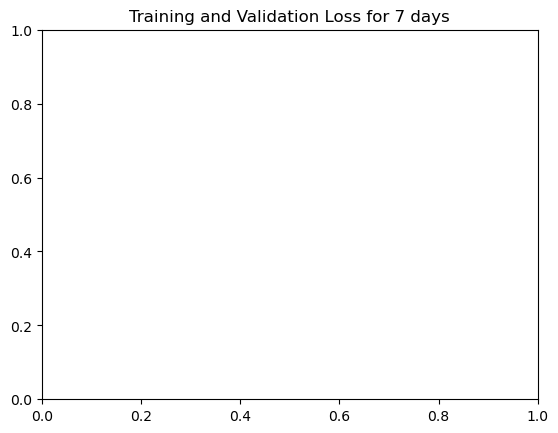

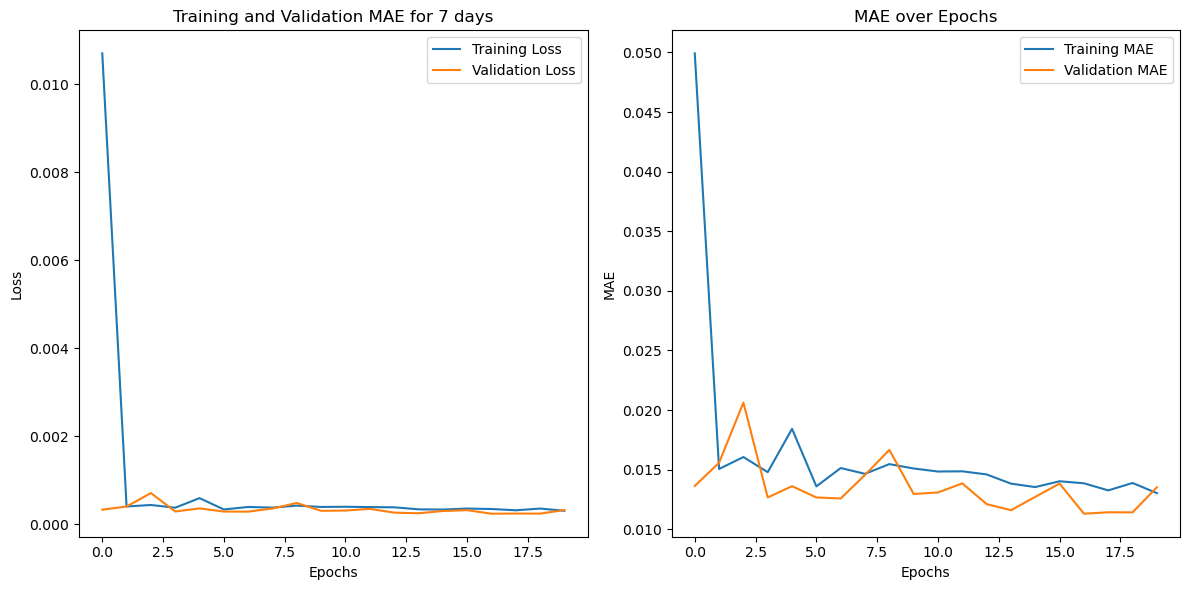

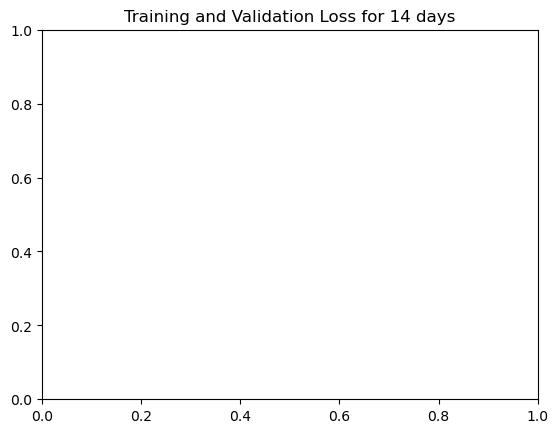

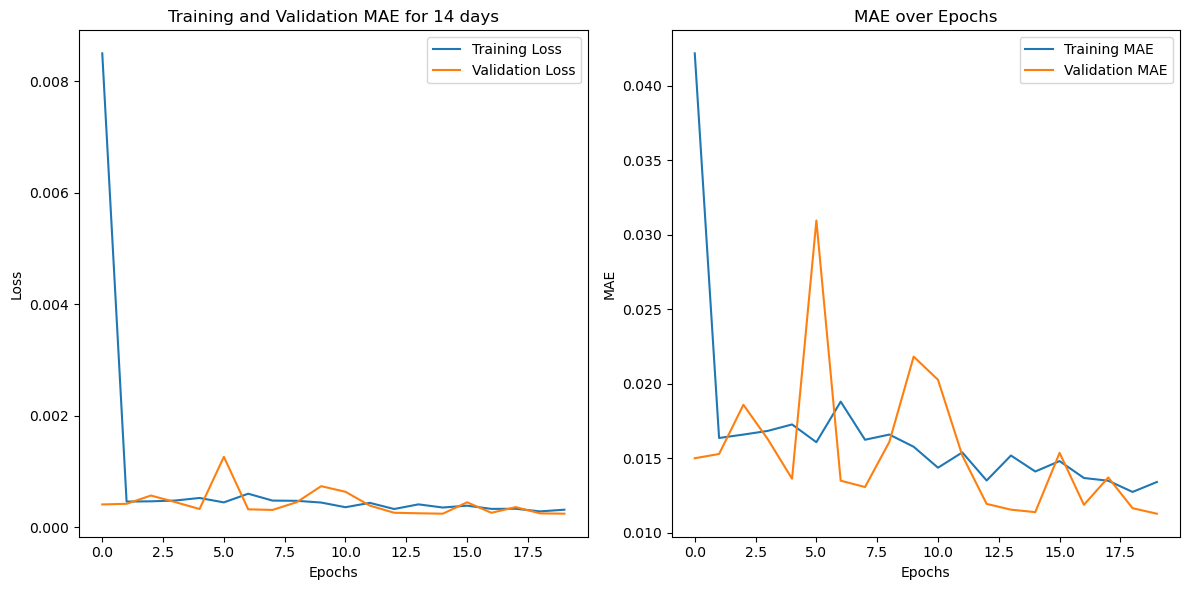

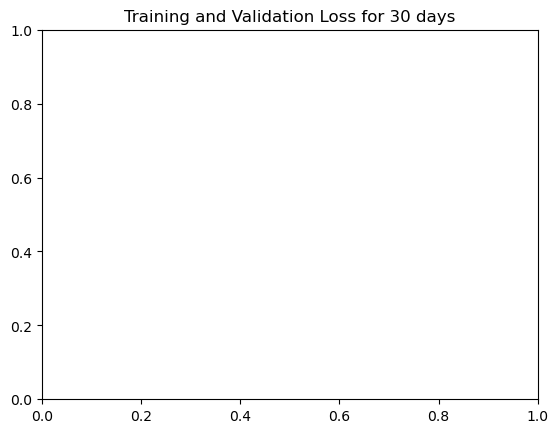

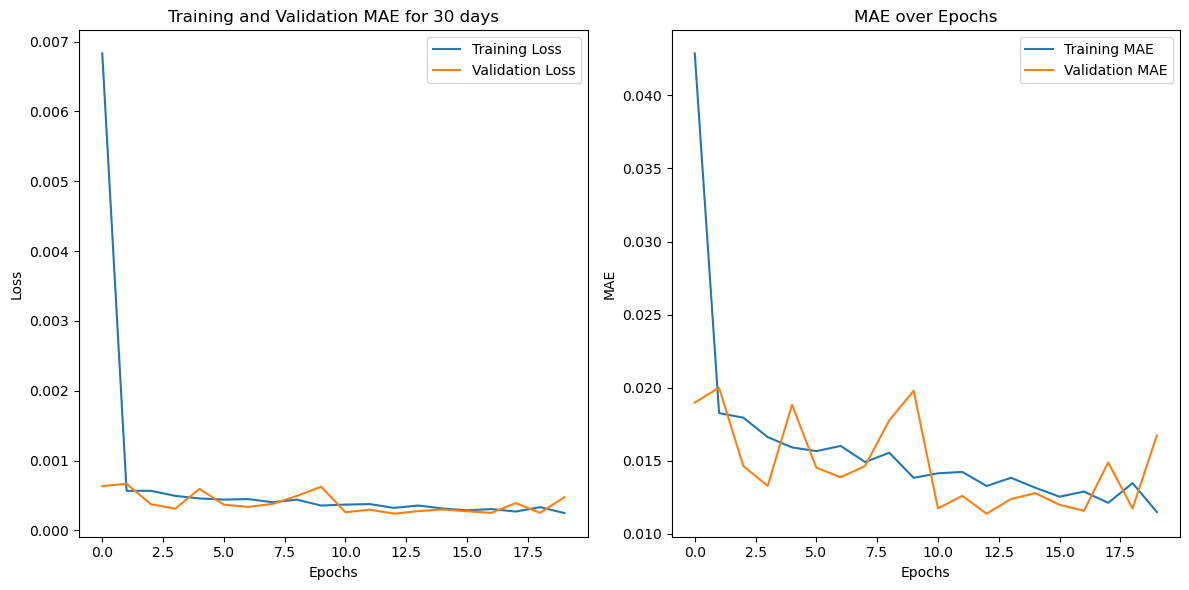

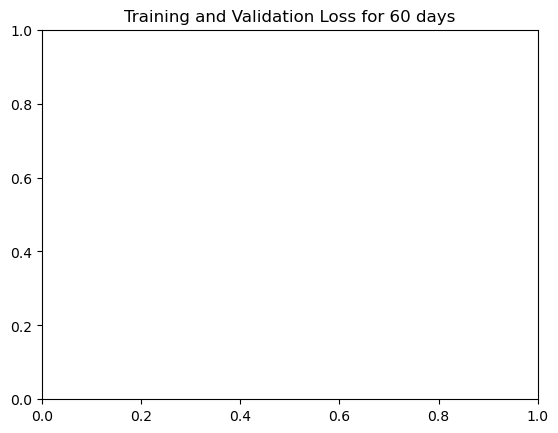

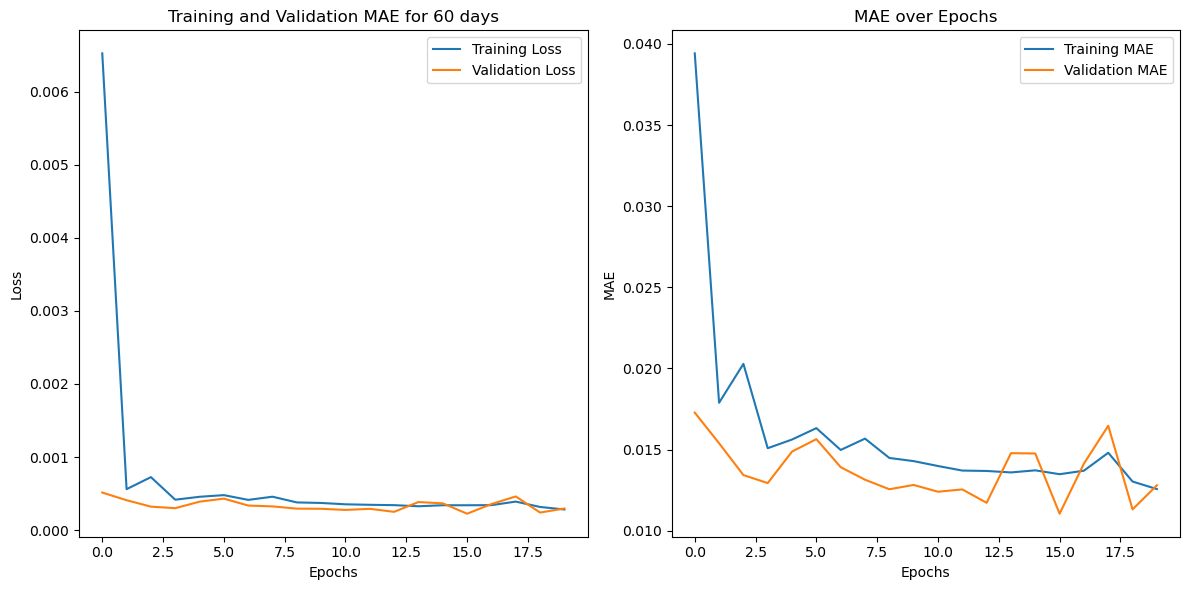

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0360 - mae: 0.1172 - val_loss: 2.6953e-04 - val_mae: 0.0118
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5427e-04 - mae: 0.0117 - val_loss: 2.3911e-04 - val_mae: 0.0113
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7350e-04 - mae: 0.0122 - val_loss: 2.1812e-04 - val_mae: 0.0106
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5737e-04 - mae: 0.0118 - val_loss: 3.5896e-04 - val_mae: 0.0138
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4713e-04 - mae: 0.0116 - val_loss: 2.4965e-04 - val_mae: 0.0113
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6641e-04 - mae: 0.0120 - val_loss: 2.2473e-04 - val_mae: 0.0108
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7789e-04 - mae: 0.0123 - val_loss: 2.5301e-04 - val_mae: 0.0116
Epoch 8/20

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0415 - mae: 0.1214 - val_loss: 2.6766e-04 - val_mae: 0.0121
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6162e-04 - mae: 0.0123 - val_loss: 2.2630e-04 - val_mae: 0.0109
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7900e-04 - mae: 0.0123 - val_loss: 2.4609e-04 - val_mae: 0.0113
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2353e-04 - mae: 0.0109 - val_loss: 2.1931e-04 - val_mae: 0.0107
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2630e-04 - mae: 0.0110 - val_loss: 3.1192e-04 - val_mae: 0.0131
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2640e-04 - mae: 0.0111 - val_loss: 3.0083e-04 - val_mae: 0.0130
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2832e-04 - mae: 0.0111 - val_loss: 2.0076e-04 - val_mae: 0.01

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0685 - mae: 0.1689 - val_loss: 2.9533e-04 - val_mae: 0.0128
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8939e-04 - mae: 0.0123 - val_loss: 2.2142e-04 - val_mae: 0.0109
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5720e-04 - mae: 0.0117 - val_loss: 2.1834e-04 - val_mae: 0.0109
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3250e-04 - mae: 0.0110 - val_loss: 2.3495e-04 - val_mae: 0.0113
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3973e-04 - mae: 0.0112 - val_loss: 2.1520e-04 - val_mae: 0.0106
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4758e-04 - mae: 0.0113 - val_loss: 1.9577e-04 - val_mae: 0.0101
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4008e-04 - mae: 0.0112 - val_loss: 1.9622e-04 - val_m

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0435 - mae: 0.1259 - val_loss: 2.8896e-04 - val_mae: 0.0127
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.5345e-04 - mae: 0.0118 - val_loss: 6.7325e-04 - val_mae: 0.0207
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.4614e-04 - mae: 0.0117 - val_loss: 2.0238e-04 - val_mae: 0.0102
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.3306e-04 - mae: 0.0111 - val_loss: 4.1274e-04 - val_mae: 0.0159
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.2794e-04 - mae: 0.0111 - val_loss: 2.0011e-04 - val_mae: 0.0103
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.9842e-04 - mae: 0.0104 - val_loss: 2.1022e-04 - val_mae: 0.0104
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.3421e-04 - mae: 0.0111 - val_loss: 5.6716e-04 - val_m

Model trained on 60 days has been saved.


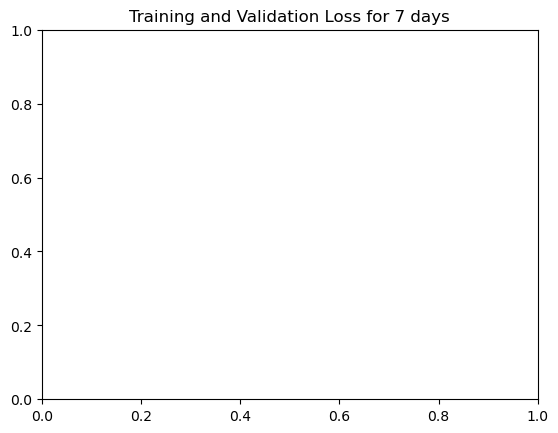

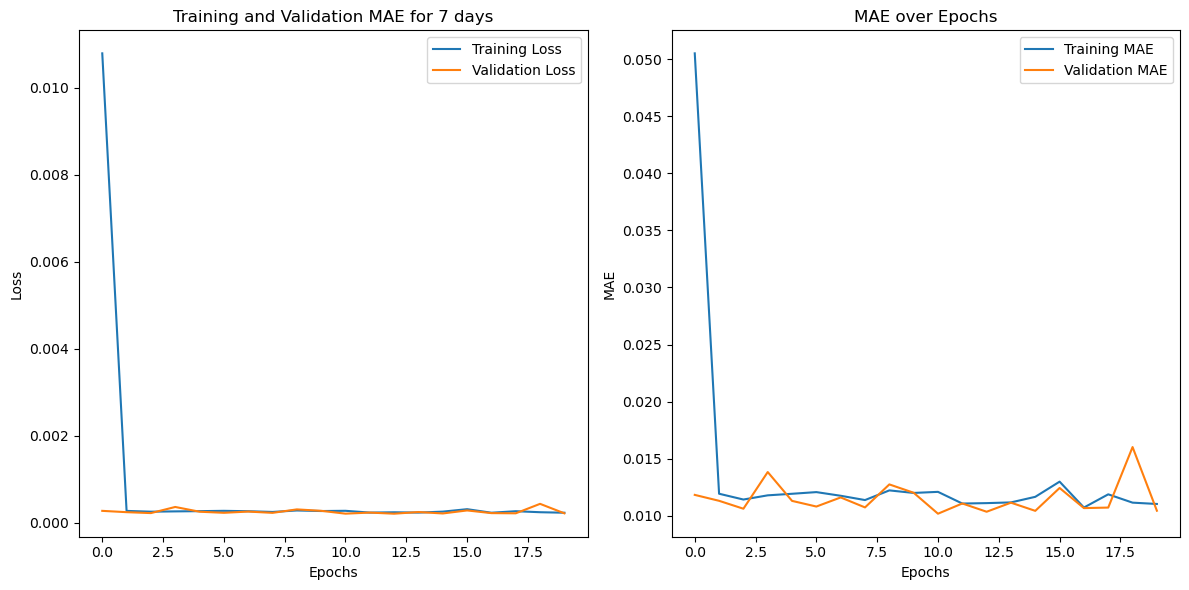

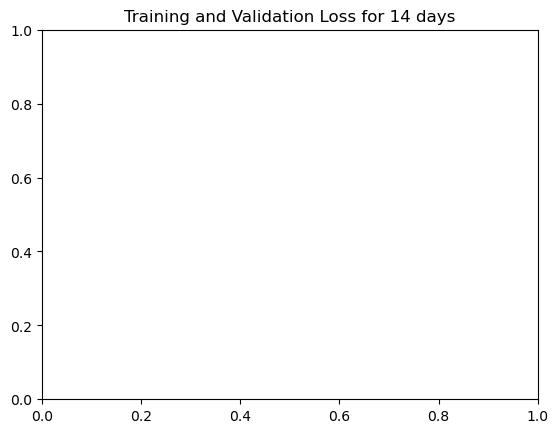

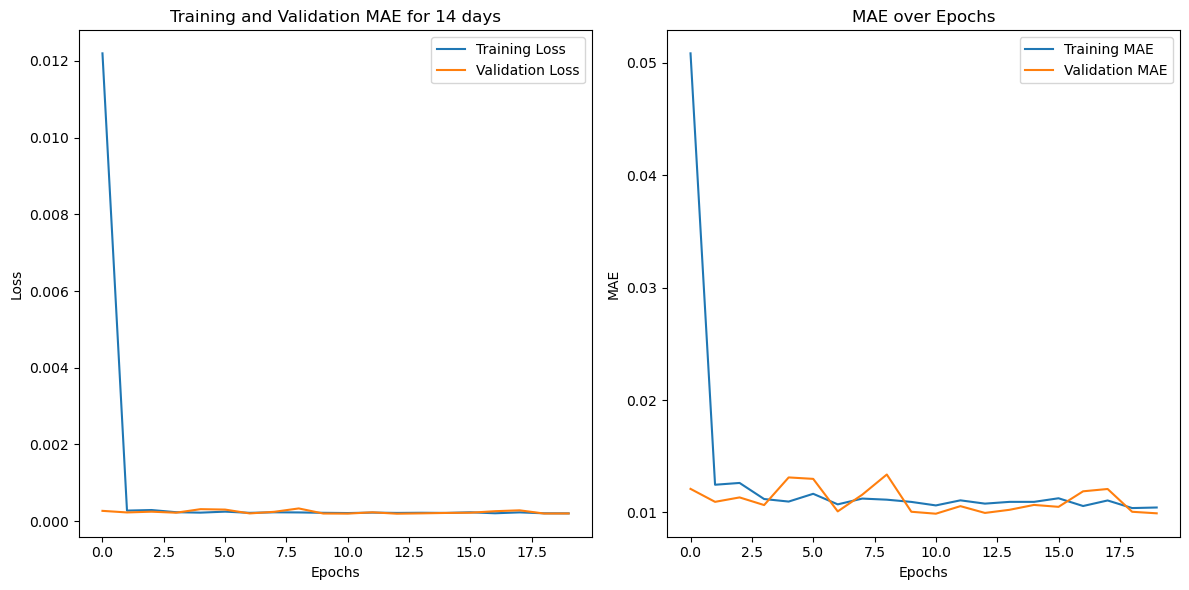

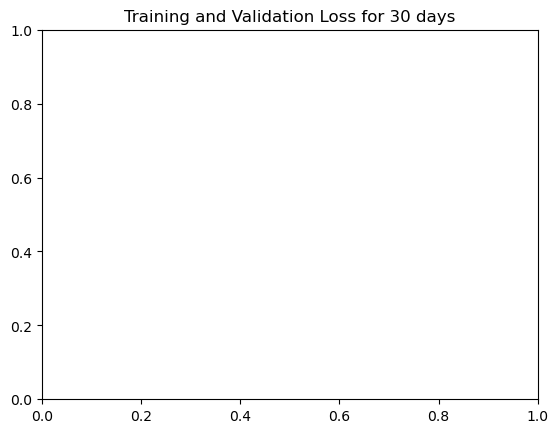

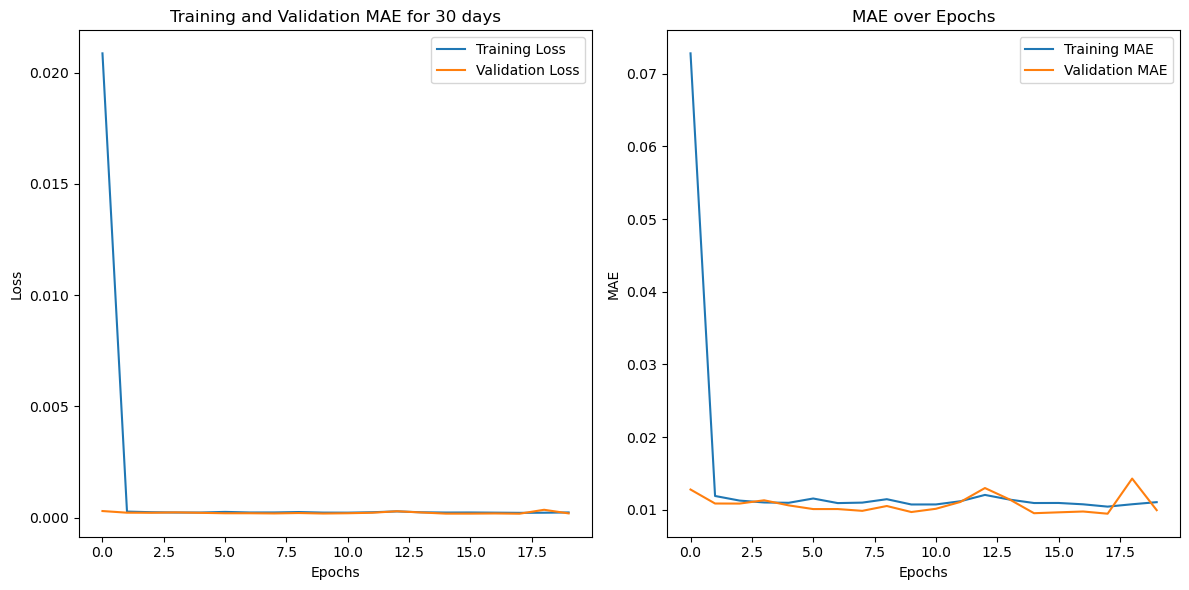

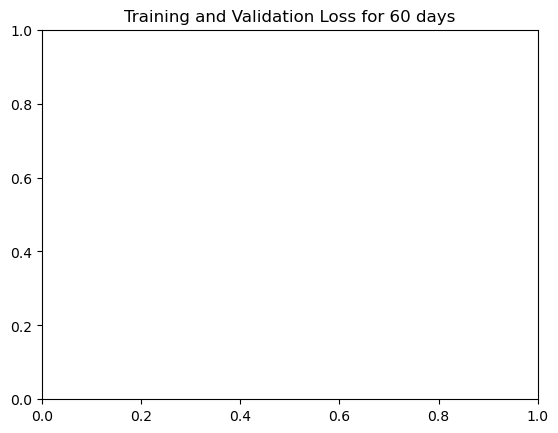

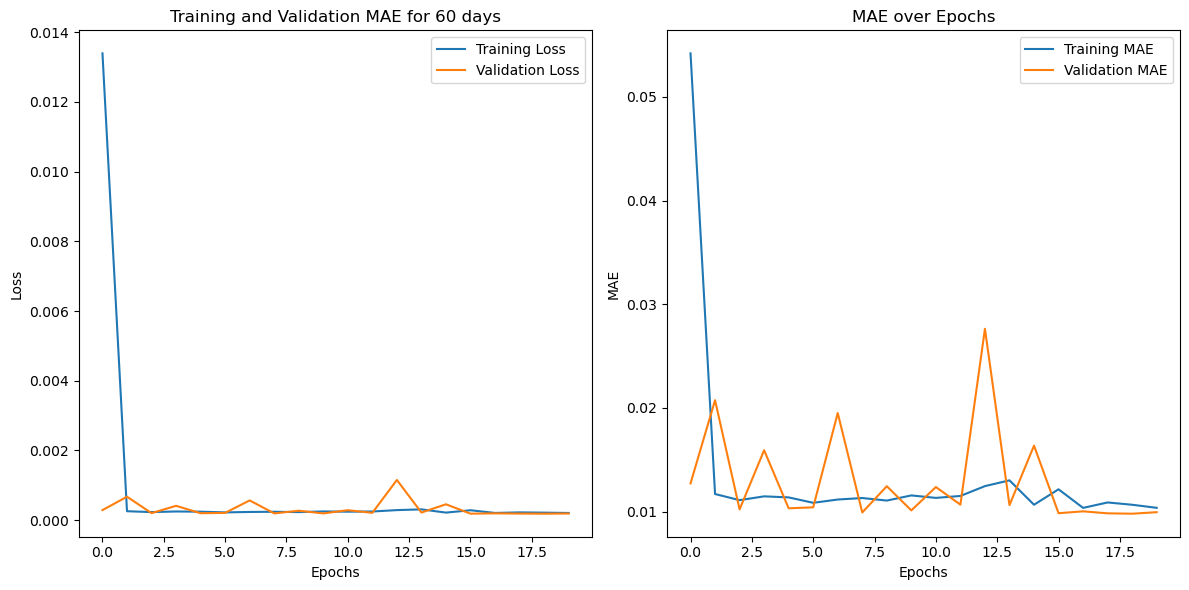

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0787 - mae: 0.1979 - val_loss: 3.2371e-04 - val_mae: 0.0133
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3563e-04 - mae: 0.0134 - val_loss: 6.1080e-04 - val_mae: 0.0196
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9413e-04 - mae: 0.0149 - val_loss: 3.5161e-04 - val_mae: 0.0140
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8379e-04 - mae: 0.0126 - val_loss: 3.4627e-04 - val_mae: 0.0141
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9524e-04 - mae: 0.0126 - val_loss: 7.9559e-04 - val_mae: 0.0231
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7458e-04 - mae: 0.0143 - val_loss: 6.0615e-04 - val_mae: 0.0190
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4386e-04 - mae: 0.0158 - val_loss: 2.6544e-04 - val_mae: 0.0118
Epoch 8/20

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0536 - mae: 0.1471 - val_loss: 7.5841e-04 - val_mae: 0.0215
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4075e-04 - mae: 0.0201 - val_loss: 4.8571e-04 - val_mae: 0.0164
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4960e-04 - mae: 0.0207 - val_loss: 4.5899e-04 - val_mae: 0.0157
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8366e-04 - mae: 0.0180 - val_loss: 4.9348e-04 - val_mae: 0.0166
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2279e-04 - mae: 0.0173 - val_loss: 6.6245e-04 - val_mae: 0.0197
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2470e-04 - mae: 0.0173 - val_loss: 0.0017 - val_mae: 0.0334
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3736e-04 - mae: 0.0184 - val_loss: 4.6925e-04 - val_mae: 0.0161
E

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0404 - mae: 0.1229 - val_loss: 9.7734e-04 - val_mae: 0.0241
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0238 - val_loss: 9.3215e-04 - val_mae: 0.0231
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.3597e-04 - mae: 0.0232 - val_loss: 7.4552e-04 - val_mae: 0.0209
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.4203e-04 - mae: 0.0214 - val_loss: 6.2408e-04 - val_mae: 0.0190
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 7.3765e-04 - val_mae: 0.0213
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4485e-04 - mae: 0.0205 - val_loss: 5.9999e-04 - val_mae: 0.0187
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2435e-04 - mae: 0.0216 - val_loss: 5.7215e-04 - val_mae: 0.01

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0409 - mae: 0.1183 - val_loss: 0.0017 - val_mae: 0.0320
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012 - mae: 0.0258 - val_loss: 7.1640e-04 - val_mae: 0.0205
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0018 - val_mae: 0.0313
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014 - mae: 0.0284 - val_loss: 7.9001e-04 - val_mae: 0.0209
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0018 - val_mae: 0.0332
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.9514e-04 - mae: 0.0212 - val_loss: 7.5307e-04 - val_mae: 0.0206
Epoch 8/20
126/126 ━━━━━━

Model trained on 60 days has been saved.


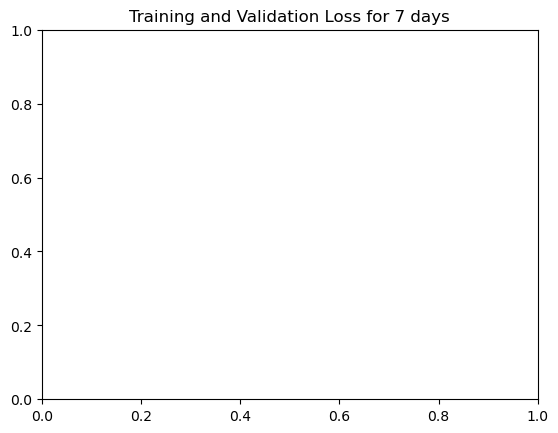

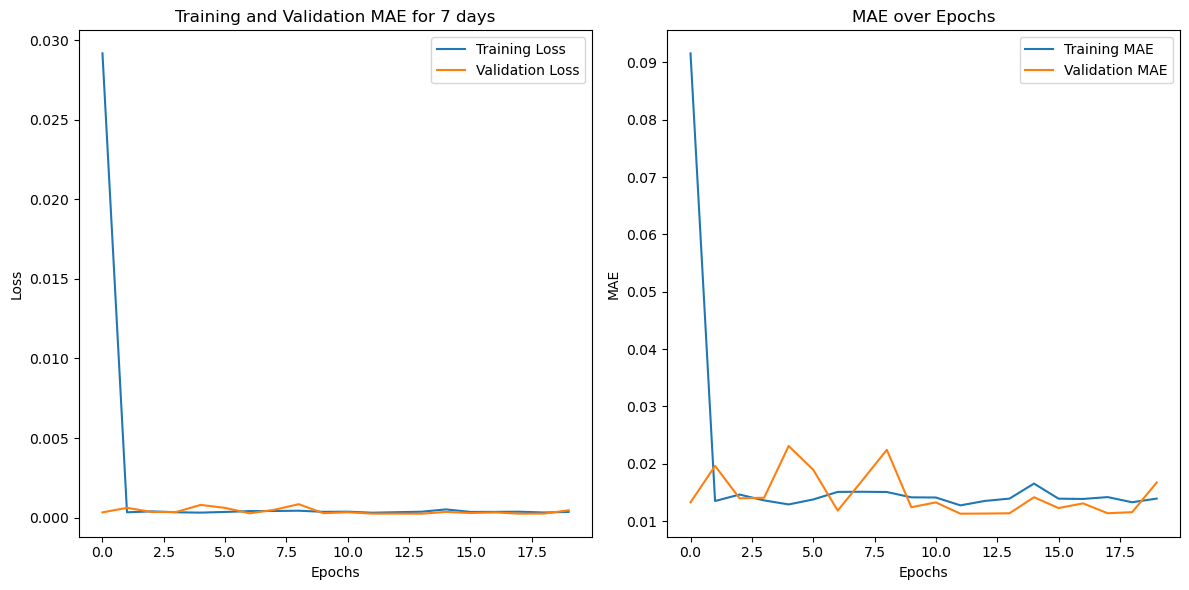

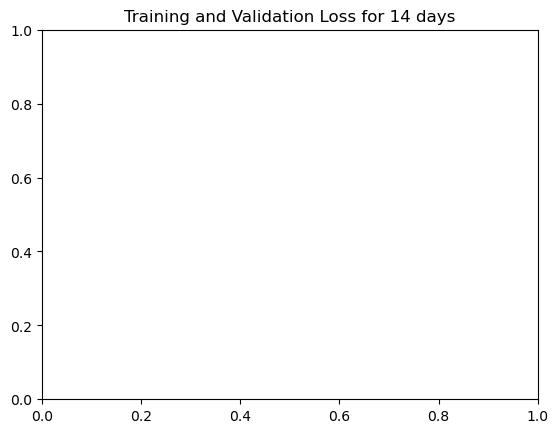

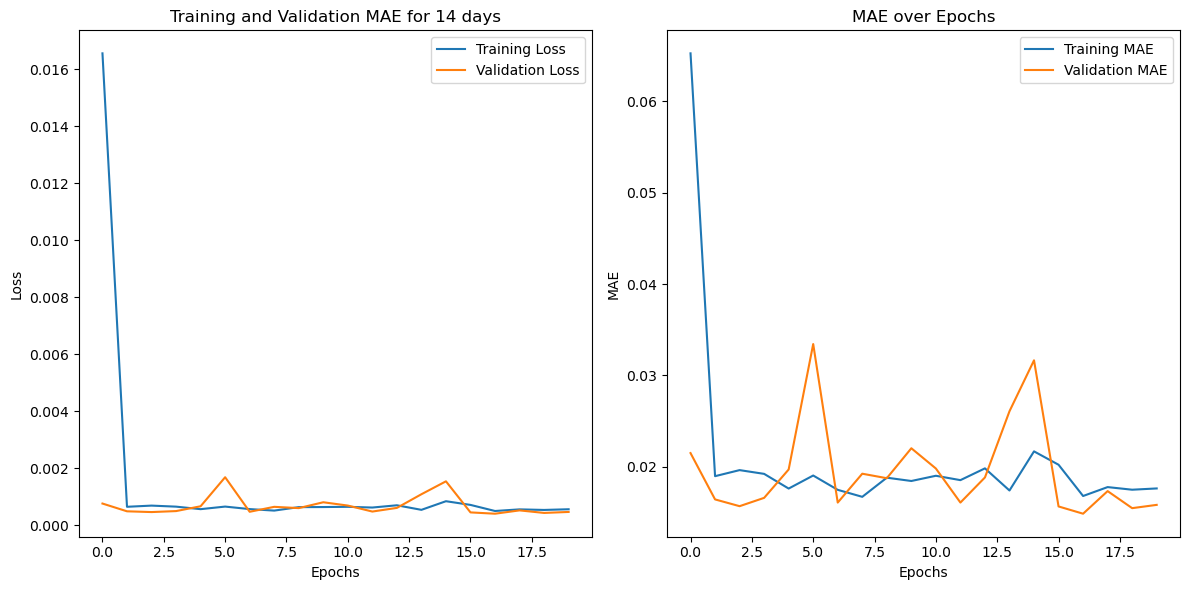

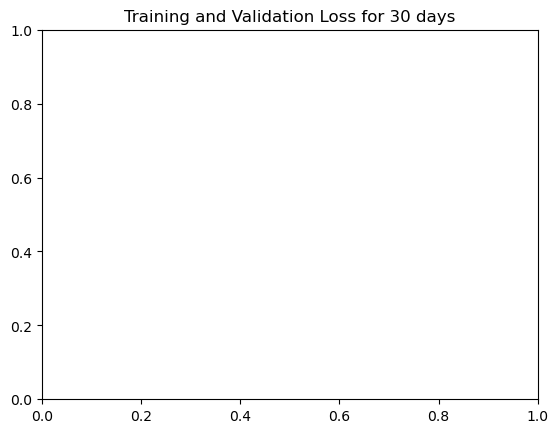

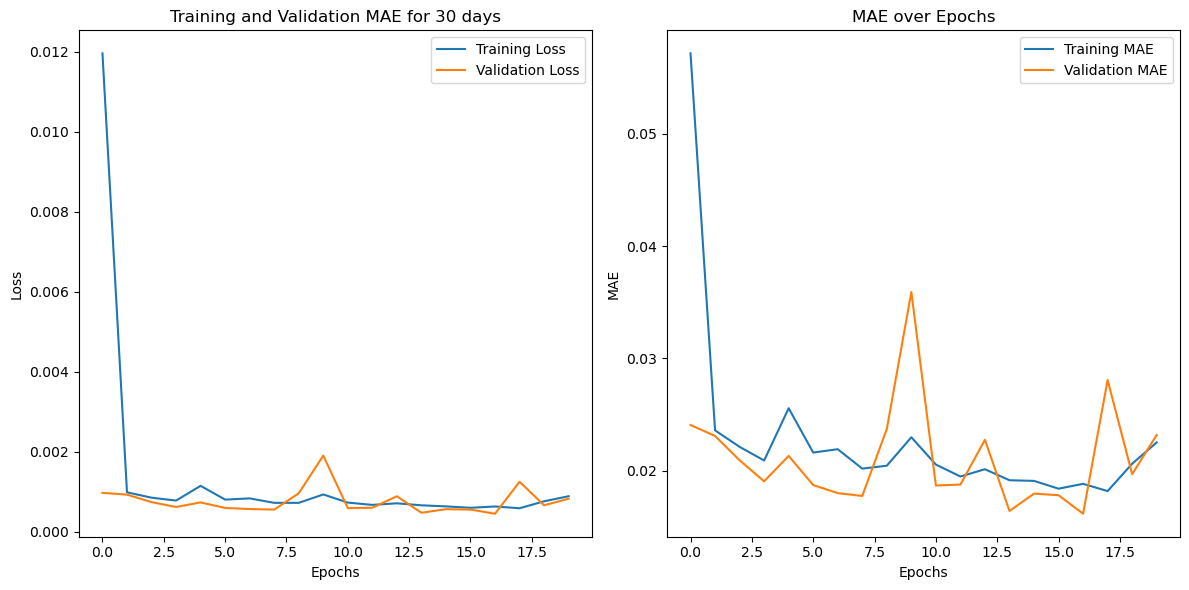

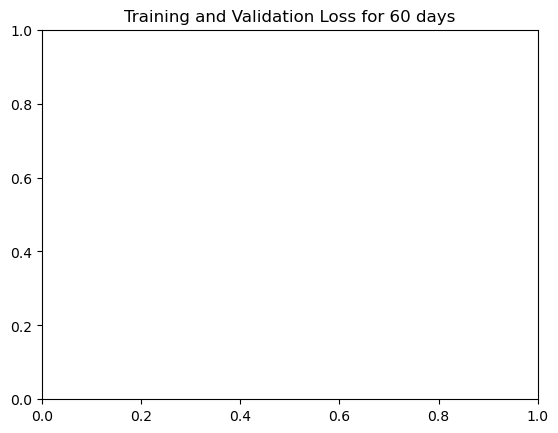

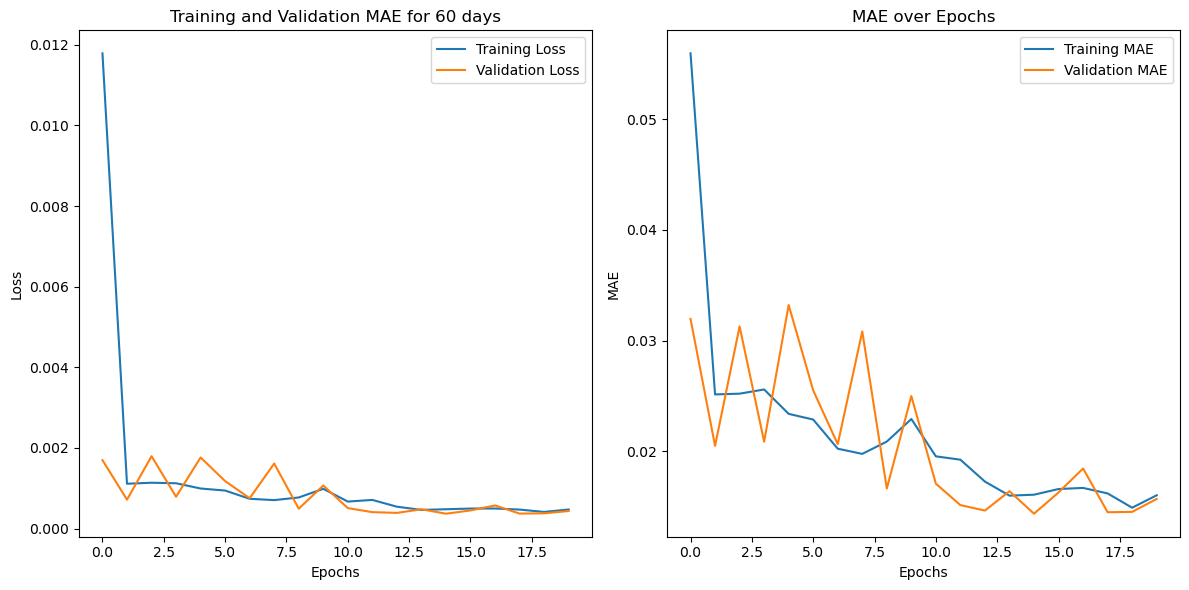

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0449 - mae: 0.1299 - val_loss: 3.8281e-04 - val_mae: 0.0148
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3743e-04 - mae: 0.0136 - val_loss: 2.7383e-04 - val_mae: 0.0121
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3900e-04 - mae: 0.0135 - val_loss: 4.9396e-04 - val_mae: 0.0171
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4257e-04 - mae: 0.0137 - val_loss: 3.2941e-04 - val_mae: 0.0135
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9839e-04 - mae: 0.0147 - val_loss: 3.5421e-04 - val_mae: 0.0143
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3316e-04 - mae: 0.0156 - val_loss: 2.8401e-04 - val_mae: 0.0122
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5631e-04 - mae: 0.0140 - val_loss: 2.6754e-04 - val_mae: 0.0119
Epoch 8/20

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0373 - mae: 0.1182 - val_loss: 4.3470e-04 - val_mae: 0.0153
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2021e-04 - mae: 0.0167 - val_loss: 4.0770e-04 - val_mae: 0.0148
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1746e-04 - mae: 0.0173 - val_loss: 4.1768e-04 - val_mae: 0.0150
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9730e-04 - mae: 0.0186 - val_loss: 6.3334e-04 - val_mae: 0.0192
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2322e-04 - mae: 0.0173 - val_loss: 6.2997e-04 - val_mae: 0.0185
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9909e-04 - mae: 0.0158 - val_loss: 4.0138e-04 - val_mae: 0.0147
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5768e-04 - mae: 0.0160 - val_loss: 4.2408e-04 - val_mae: 0.01

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0256 - mae: 0.0972 - val_loss: 7.0366e-04 - val_mae: 0.0205
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9128e-04 - mae: 0.0198 - val_loss: 4.5577e-04 - val_mae: 0.0159
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1543e-04 - mae: 0.0186 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6600e-04 - mae: 0.0194 - val_loss: 5.3486e-04 - val_mae: 0.0172
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5316e-04 - mae: 0.0174 - val_loss: 4.4014e-04 - val_mae: 0.0156
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3767e-04 - mae: 0.0171 - val_loss: 4.7405e-04 - val_mae: 0.0163
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6611e-04 - mae: 0.0179 - val_loss: 4.1327e-04 - val_mae: 0.0151


Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0266 - mae: 0.0931 - val_loss: 4.2345e-04 - val_mae: 0.0155
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7188e-04 - mae: 0.0159 - val_loss: 4.0392e-04 - val_mae: 0.0149
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4689e-04 - mae: 0.0175 - val_loss: 4.7106e-04 - val_mae: 0.0161
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0592e-04 - mae: 0.0179 - val_loss: 5.7134e-04 - val_mae: 0.0178
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3976e-04 - mae: 0.0154 - val_loss: 3.4706e-04 - val_mae: 0.0136
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7718e-04 - mae: 0.0145 - val_loss: 4.5686e-04 - val_mae: 0.0162
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4533e-04 - mae: 0.0159 - val_loss: 6.2806e-04 - val_m

Model trained on 60 days has been saved.


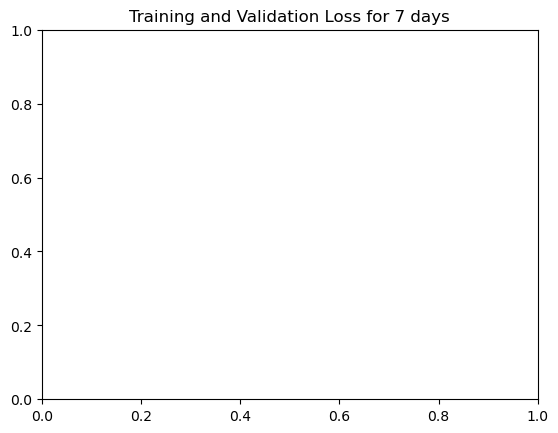

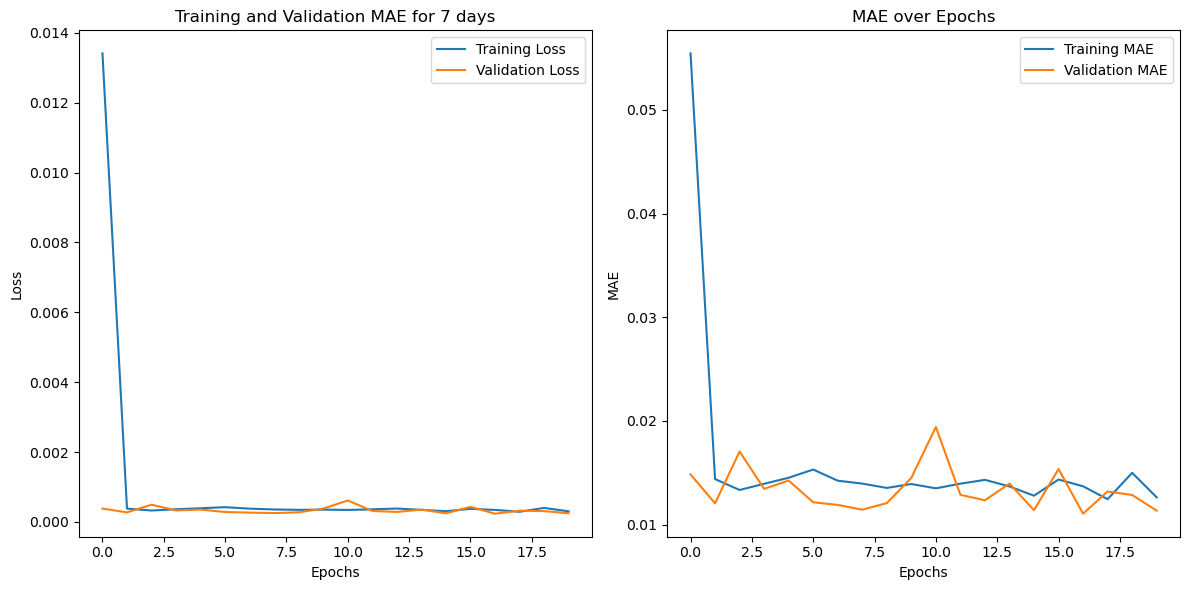

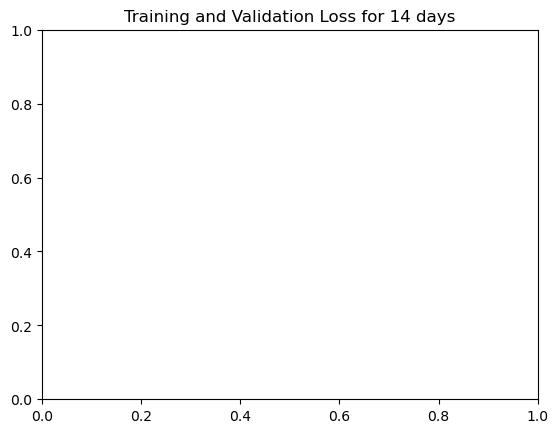

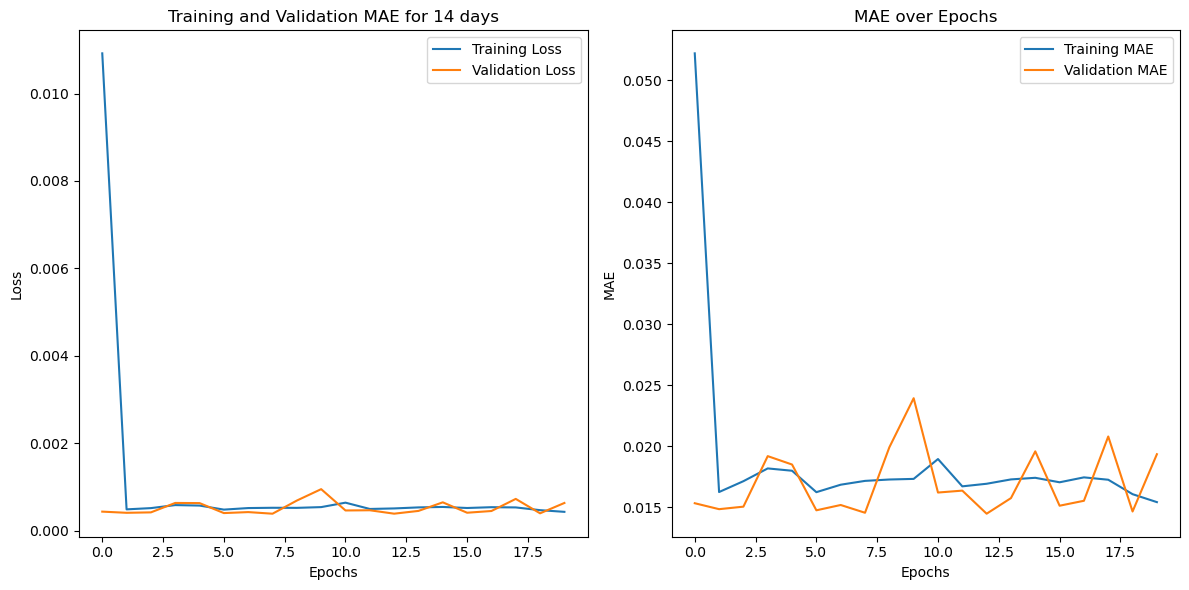

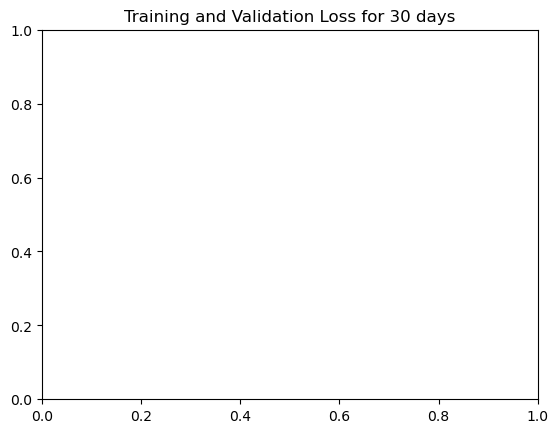

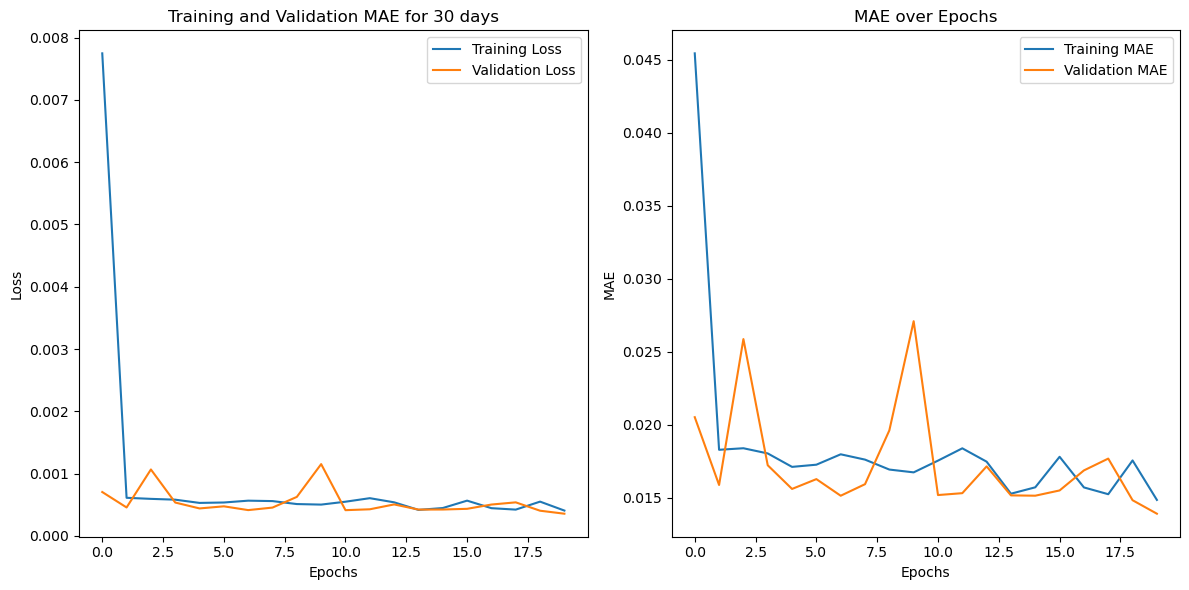

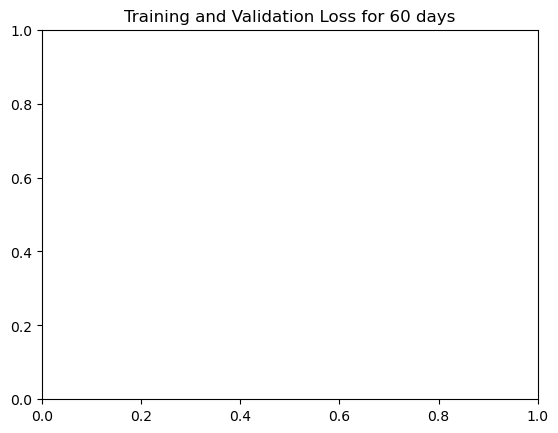

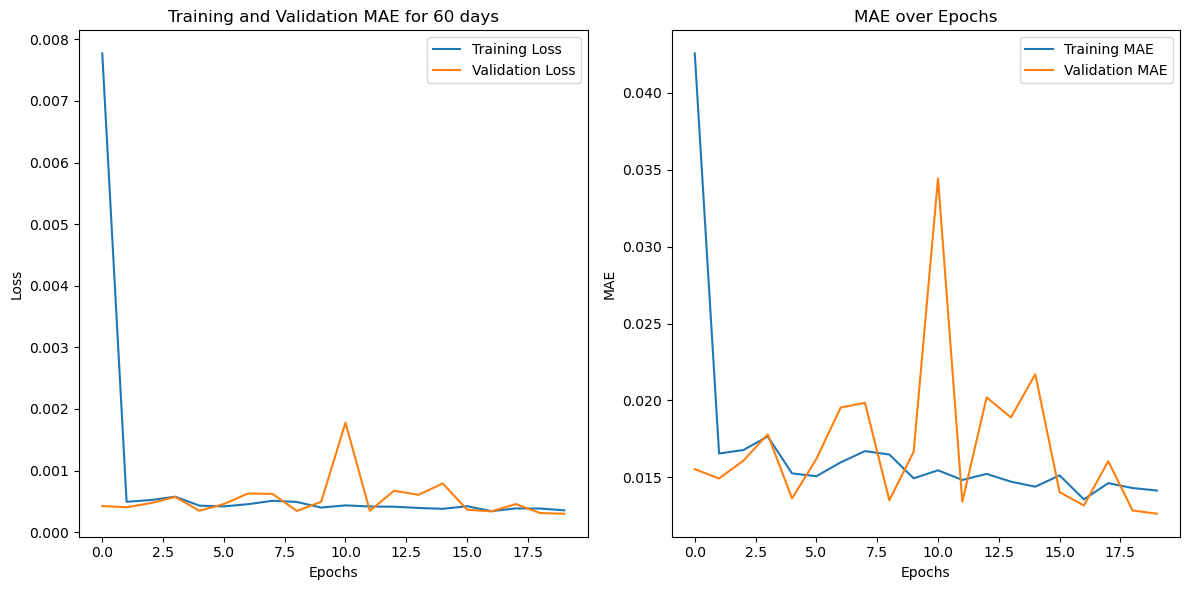

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0758 - mae: 0.1894 - val_loss: 3.3059e-04 - val_mae: 0.0134
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5729e-04 - mae: 0.0140 - val_loss: 2.7126e-04 - val_mae: 0.0119
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7070e-04 - mae: 0.0141 - val_loss: 2.5977e-04 - val_mae: 0.0117
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1784e-04 - mae: 0.0133 - val_loss: 3.8192e-04 - val_mae: 0.0148
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5509e-04 - mae: 0.0138 - val_loss: 2.3989e-04 - val_mae: 0.0113
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5078e-04 - mae: 0.0139 - val_loss: 3.4184e-04 - val_mae: 0.0140
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4561e-04 - mae: 0.0138 - val_loss: 2.5867e-04 - val_mae: 0.0116
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1934e-04 - mae: 0.0130 - val_loss: 3.0231e-04 - val_mae: 0.0135
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0598 - mae: 0.1564 - val_loss: 5.4014e-04 - val_mae: 0.0179
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5799e-04 - mae: 0.0177 - val_loss: 6.4472e-04 - val_mae: 0.0190
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9571e-04 - mae: 0.0184 - val_loss: 5.3174e-04 - val_mae: 0.0173
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.9640e-04 - mae: 0.0184 - val_loss: 4.4459e-04 - val_mae: 0.0156
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.1943e-04 - mae: 0.0180 - val_loss: 6.6472e-04 - val_mae: 0.0199
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4670e-04 - mae: 0.0189 - val_loss: 5.3724e-04 - val_mae: 0.0176
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3170e-04 - mae: 0.0203 - val_loss: 8.0860e-04 - val_mae: 0.02

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0399 - mae: 0.1187 - val_loss: 8.5470e-04 - val_mae: 0.0222
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0013 - val_mae: 0.0284
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.5706e-04 - mae: 0.0223 - val_loss: 7.1817e-04 - val_mae: 0.0204
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0016 - mae: 0.0302 - val_loss: 7.1390e-04 - val_mae: 0.0208
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.8372e-04 - mae: 0.0224 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0542e-04 - mae: 0.0231 - val_loss: 7.4913e-04 - val_mae: 0.0204
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4232e-04 - mae: 0.0206 - val_loss: 6.9802e-04 - val_mae: 0.0201
Epoch

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0295 - mae: 0.1083 - val_loss: 0.0049 - val_mae: 0.0582
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0023 - mae: 0.0362 - val_loss: 0.0013 - val_mae: 0.0286
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0010 - val_mae: 0.0255
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 9.8951e-04 - val_mae: 0.0243
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0019 - val_mae: 0.0344
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015 - mae: 0.0294 - val_loss: 0.0012 - val_mae: 0.0277
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━

Model trained on 60 days has been saved.


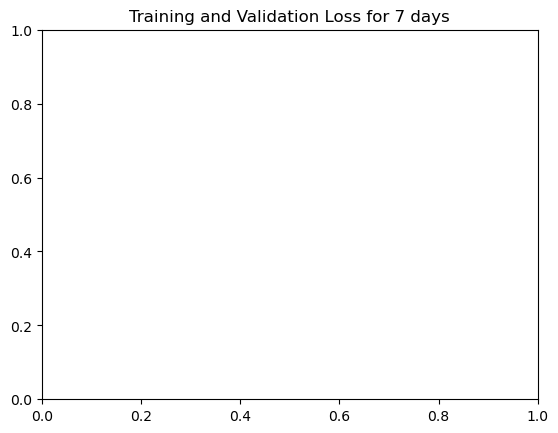

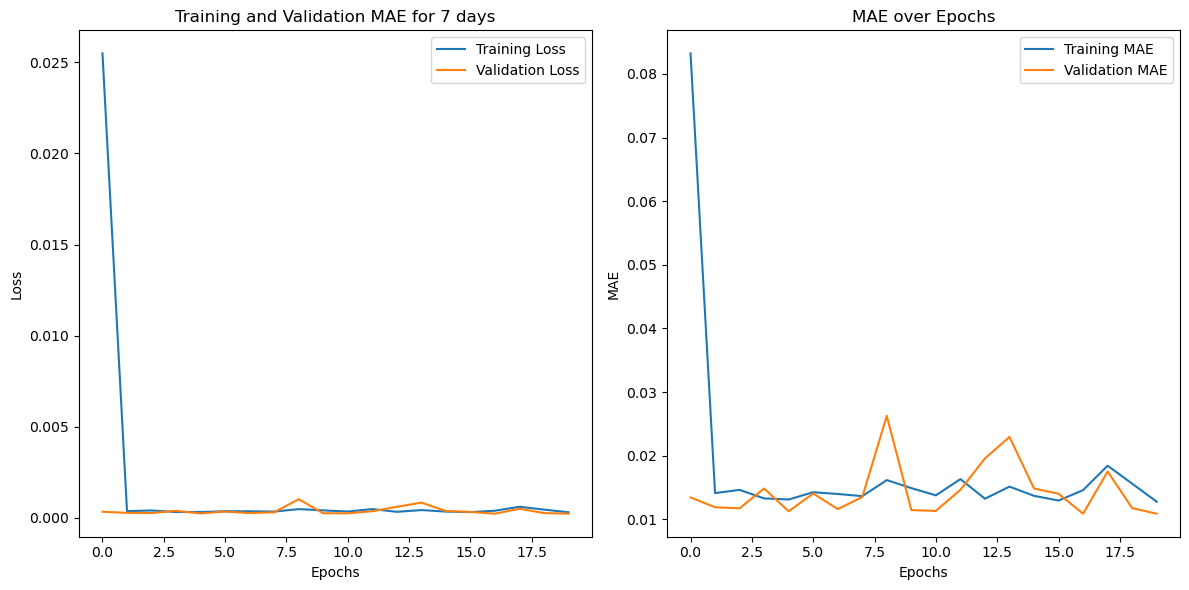

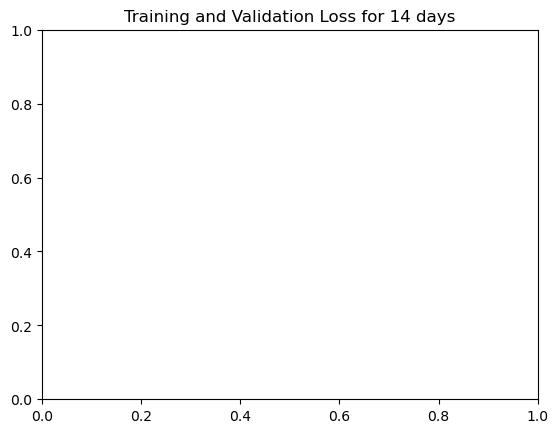

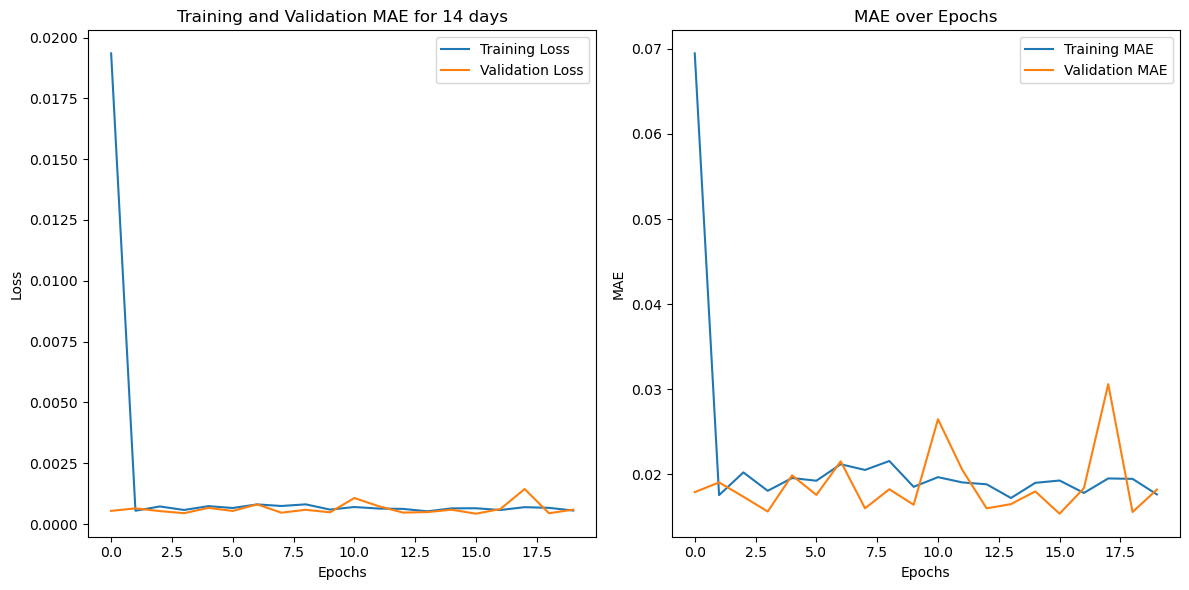

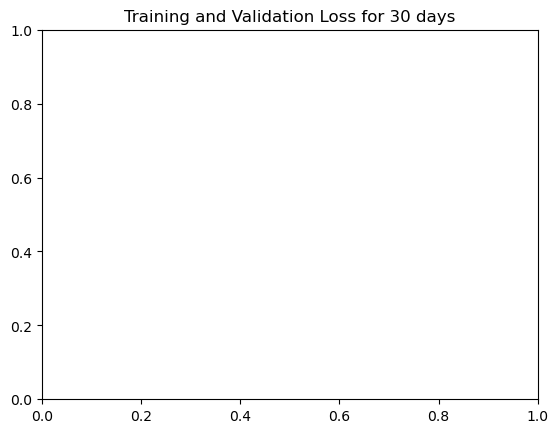

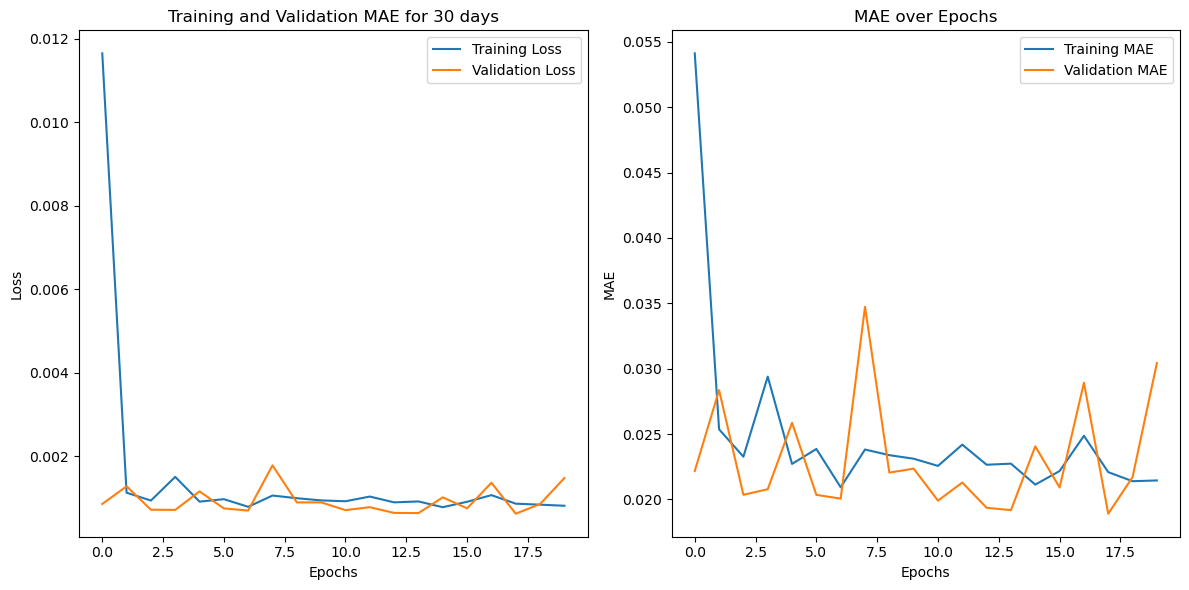

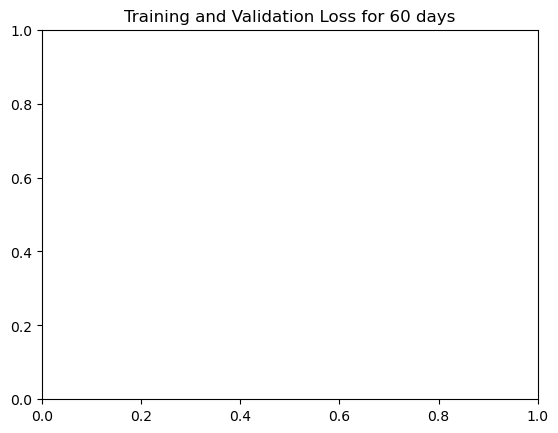

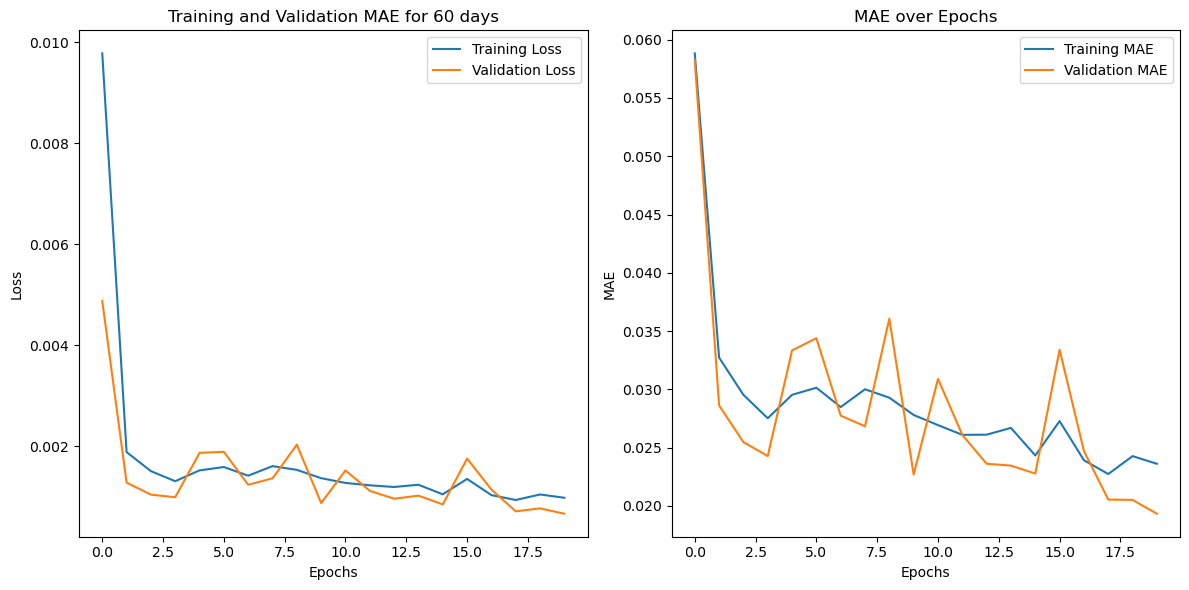

Folder '20250128' is ready.
Data for 7 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0289 - mae: 0.1031 - val_loss: 2.8395e-04 - val_mae: 0.0121
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3866e-04 - mae: 0.0135 - val_loss: 2.8096e-04 - val_mae: 0.0119
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3352e-04 - mae: 0.0132 - val_loss: 2.7465e-04 - val_mae: 0.0118
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4400e-04 - mae: 0.0137 - val_loss: 2.6458e-04 - val_mae: 0.0117
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4203e-04 - mae: 0.0136 - val_loss: 2.6076e-04 - val_mae: 0.0117
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3324e-04 - mae: 0.0134 - val_loss: 2.5917e-04 - val_mae: 0.0116
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8042e-04 - mae: 0.0144 - val_loss: 2.7959e-04 - val_mae: 0.0121
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2614e-04 - mae: 0.0133 - val_loss: 2.7836e-04 - val_mae: 0.0120
Epoch 9

Model trained on 7 days has been saved.
Data for 14 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0329 - mae: 0.1101 - val_loss: 4.3264e-04 - val_mae: 0.0154
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4602e-04 - mae: 0.0156 - val_loss: 4.2128e-04 - val_mae: 0.0152
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9237e-04 - mae: 0.0168 - val_loss: 4.7749e-04 - val_mae: 0.0161
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5550e-04 - mae: 0.0175 - val_loss: 4.2332e-04 - val_mae: 0.0152
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0920e-04 - mae: 0.0168 - val_loss: 4.3664e-04 - val_mae: 0.0156
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9771e-04 - mae: 0.0166 - val_loss: 4.2628e-04 - val_mae: 0.0152
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3484e-04 - mae: 0.0172 - val_loss: 4.7205e-04 - val_mae: 0.01

Model trained on 14 days has been saved.
Data for 30 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0304 - mae: 0.1118 - val_loss: 7.1340e-04 - val_mae: 0.0200
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5516e-04 - mae: 0.0222 - val_loss: 6.3780e-04 - val_mae: 0.0192
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6353e-04 - mae: 0.0195 - val_loss: 8.5852e-04 - val_mae: 0.0221
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4419e-04 - mae: 0.0192 - val_loss: 6.6076e-04 - val_mae: 0.0192
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8053e-04 - mae: 0.0225 - val_loss: 7.1094e-04 - val_mae: 0.0205
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0169e-04 - mae: 0.0213 - val_loss: 6.9576e-04 - val_mae: 0.0203
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1876e-04 - mae: 0.0204 - val_loss: 6.2261e-04 - val_mae: 0.

Model trained on 30 days has been saved.
Data for 60 days loaded.
Data split into training and testing sets.
start training:

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0321 - mae: 0.1036 - val_loss: 9.1633e-04 - val_mae: 0.0234
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0281 - val_loss: 9.5539e-04 - val_mae: 0.0241
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 9.3289e-04 - val_mae: 0.0240
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 8.4498e-04 - val_mae: 0.0226
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0021 - val_mae: 0.0356
Epoch 8/20
126/126 ━━━━━━

Model trained on 60 days has been saved.


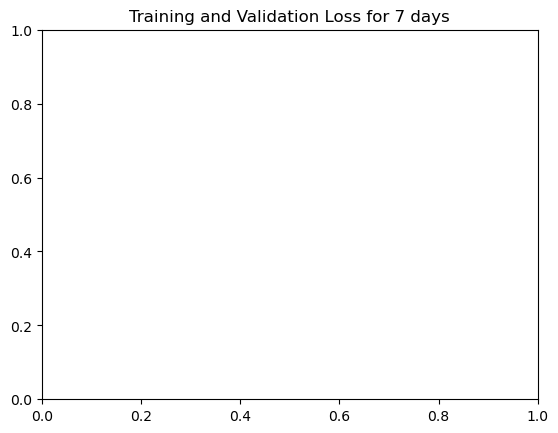

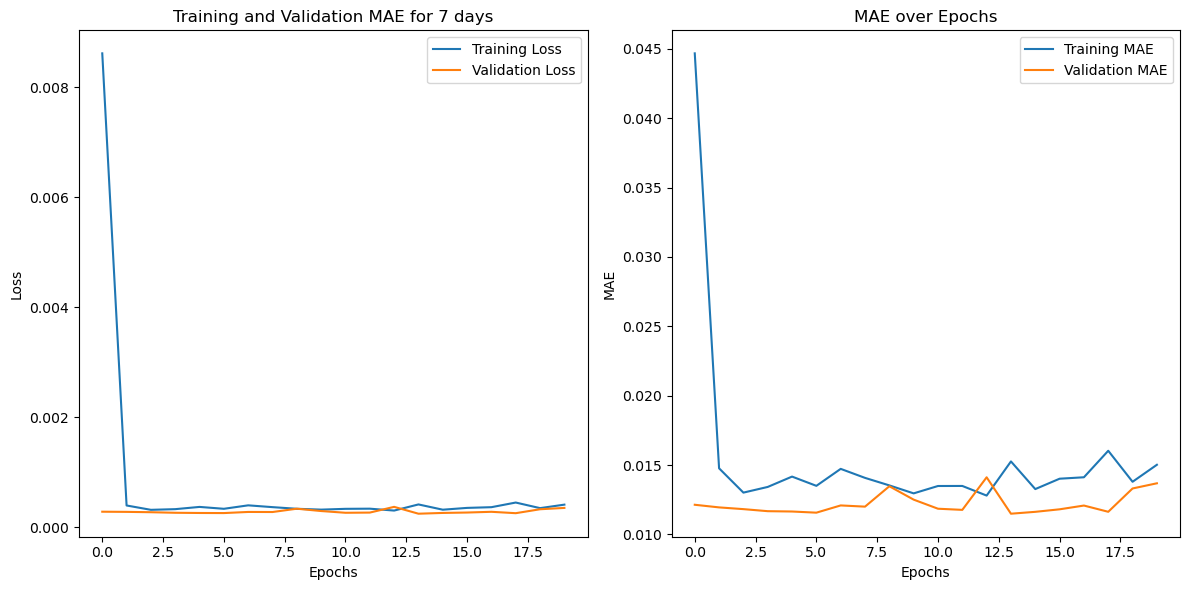

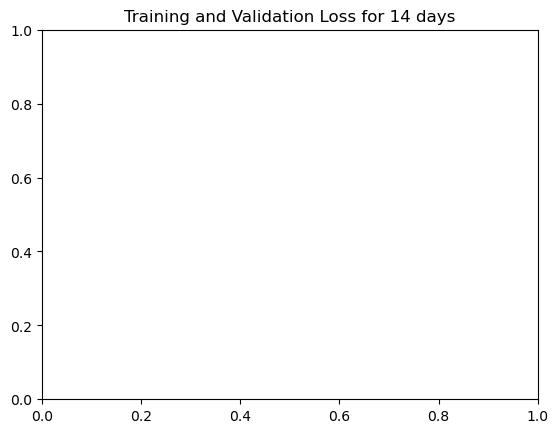

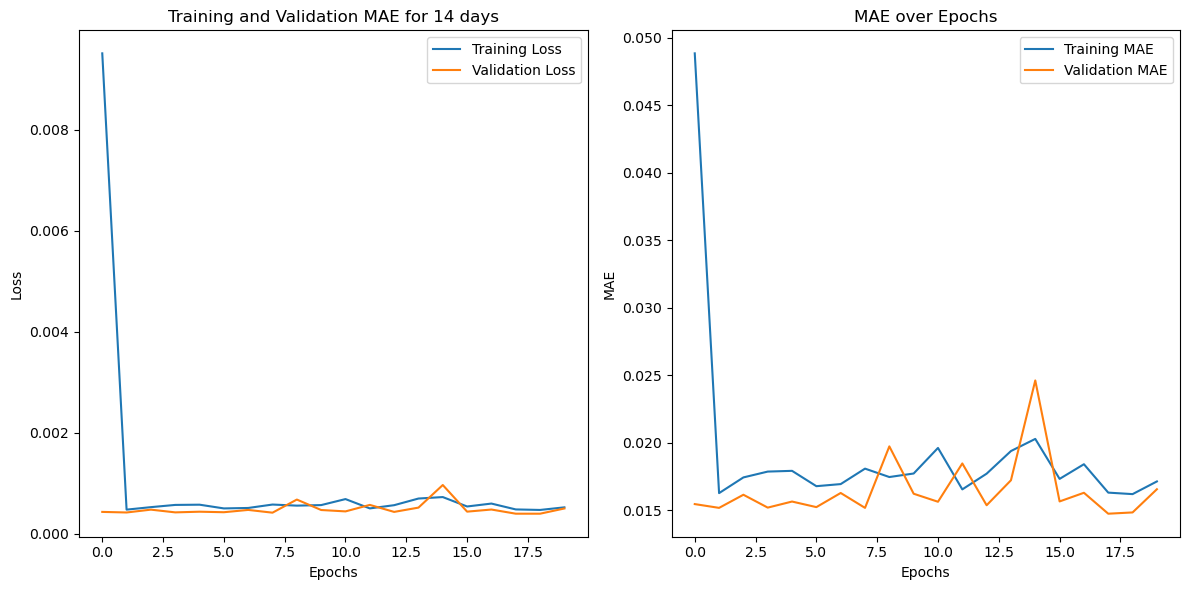

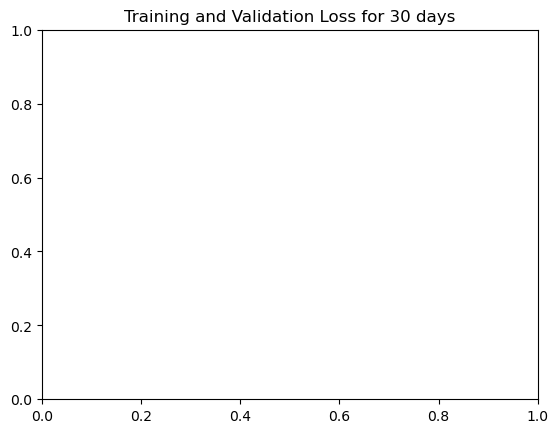

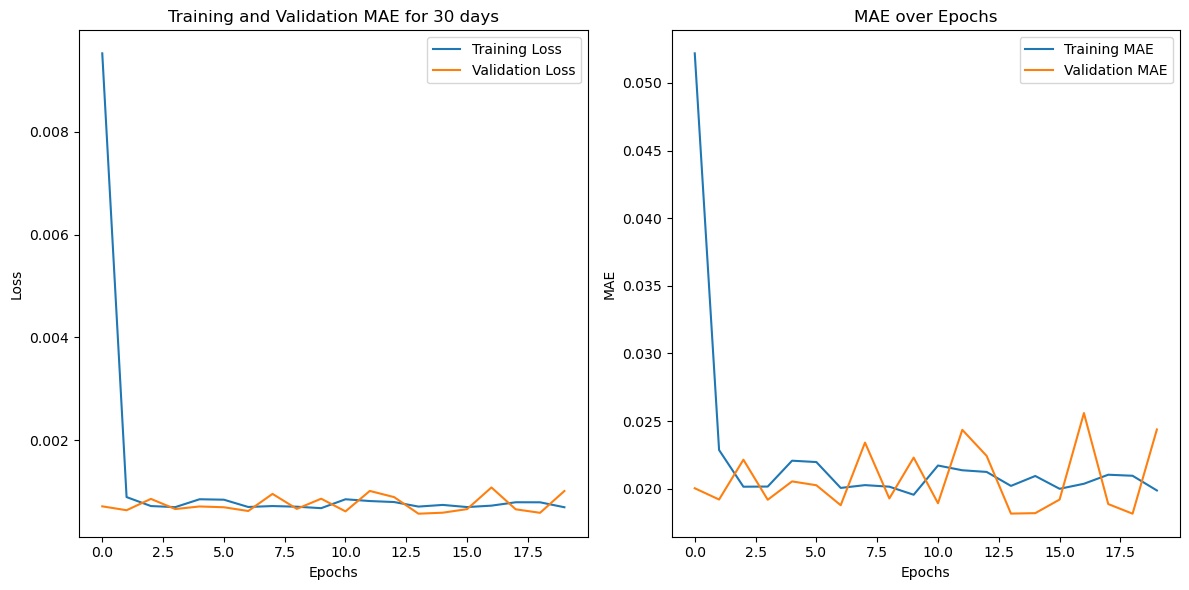

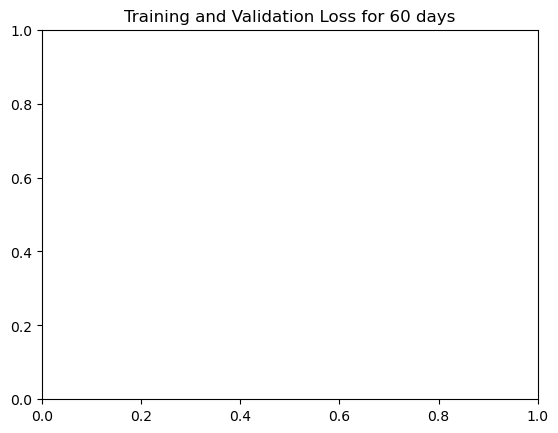

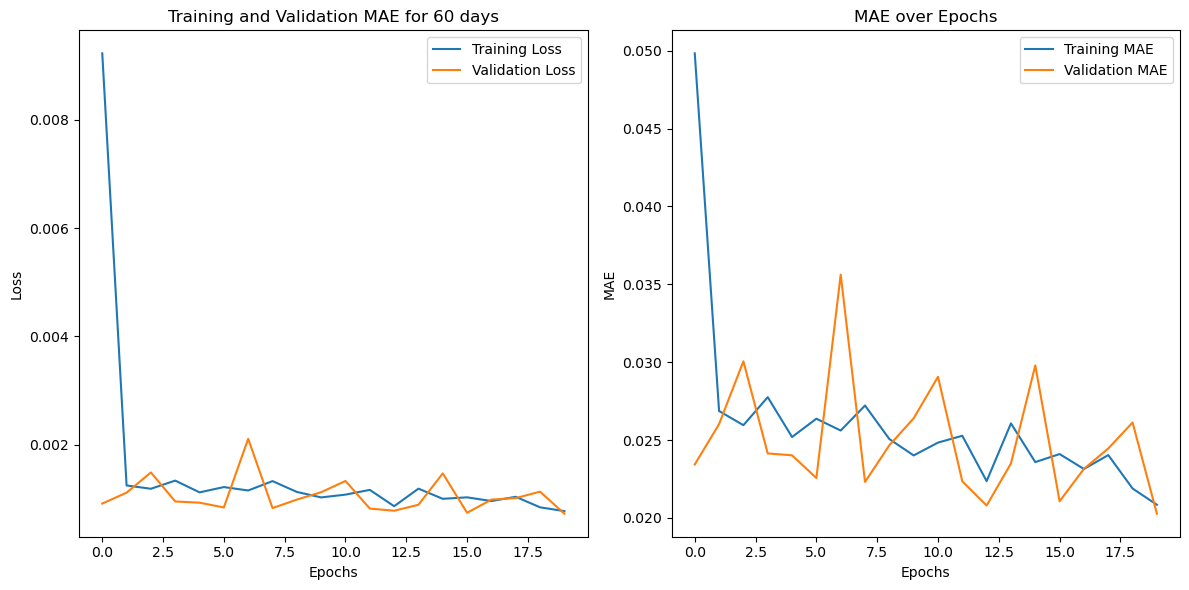

In [141]:
function_list = [baseline_LSTM_model, 
                 baseline_GRU_model, 
                 CNN_LSTM_model, 
                 CNN_GRU_model, 
                 CNN_LSTM_SA_model, 
                 CNN_GRU_SA_model]
for model_function in function_list:
    model_history = base_training(model_function, 
                                  loading_path = "/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_i_v5_pkl/", 
                                  saving_path="/Users/hoyinchui/Desktop/tbot-st-ta/saved models/",
                                  version_name="20250128"
                                  )
    plot_training_history(model_history)

Build ensemble model with meta mode (transfer learning/fine-tuning), since will do back propaggation through the ensemble layer all the way to the individual model, we can use multiple stock training data for the individual model, increase the generalization, and do the tuning with the target data, in the ensemble layer training part

In [79]:
from tensorflow.keras.models import Model
def ensemble_stacking (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.concatenate(models_outputs, axis=-1)
    #searching method for removing the last layer of the model, and directly inputting weight into stackinng model
    
    #stacking model
    merged_output = layers.Dense(64, activation='relu')(merged_output)
    merged_output = layers.Dense(output_days * output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


    

In [85]:
def ensemble_weighting (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.Add()(models_outputs)
    merged_output = layers.Dense(output_days*output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


In [96]:
#need more understanding on the MoE
''' stacking is y_p = sum(w*y_i)
    MoE is y_p = sum(g_i*y_i)
    can add other function model, like anomaly detection, to the ensemble model, since most of the data is normal, the model can be used to detect the anomaly data(Event)
'''

def ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    # Step 1: Concatenate the outputs of all the experts
    concatenated_experts = layers.concatenate(models_outputs)
    
    # Step 2: Apply a gate to weight the expert outputs
    gate = layers.Dense(len(models_outputs), activation='softmax')(concatenated_experts)
    
    # Step 3: Multiply the gate with the expert outputs
    weighted_experts = [layers.Multiply()([gate[:, i:i+1], models_outputs[i]]) for i in range(len(models_outputs))]
    
    # Step 4: Sum the weighted expert outputs
    final_expert_output = layers.Add()(weighted_experts)
    
    # Step 5: Reshape the final output to the desired shape
    final_output = layers.Reshape((output_days, output_features))(final_expert_output)

    # Step 6: Define the ensemble model
    ensemble_model = models.Model(inputs=models_inputs, outputs=final_output)

    # Step 7: Compile the model
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return ensemble_model

In [114]:
#function to load models in provided path
from tensorflow.keras.models import load_model
def load_models(path, remove_last_layer=True):
    orginal_models = []
    models_outputs = []
    models_inputs = []
    models_order = []
    for file in sorted(os.listdir(path)):
        if file.endswith(".h5"):
            model = load_model(os.path.join(path, file))
            models_order.append(file)
            print(f"Model loaded: {os.path.join(path, file)}")
            orginal_models.append(load_model(os.path.join(path, file), compile=False))
            if remove_last_layer:
                try:
                    output = model.layers[-2].output  # Use the second last layer as output
                    model = Model(inputs=model.input, outputs=output)
                    print(f"Removed final layer from model: {os.path.join(path, file)}")
                except Exception as e:
                    print(f"Error modifying model {os.path.join(path, file)}: {e}")
            models_inputs.append(model.input)
            print(models_inputs)
            models_outputs.append(model.output)
    
    
    return orginal_models, models_inputs, models_outputs, models_order



In [68]:
def ensemble_model_training(models_inputs, models_outputs, output_days, output_features, model_type = "stacking", optimizer='adam', loss='mean_squared_error', metrics=['mae']):
    if model_type == 'stacking':
        ensemble_model = ensemble_stacking(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'weighting':
        ensemble_model = ensemble_weighting(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'MoE':
        ensemble_model = ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    else:
        print("Please provide a valid model type.")
        return None
    return ensemble_model

In [115]:
#load the whole folder of models (you might have multiple floders of models, then need multiple load_models function and do the selection in the next cell)
orginal_models, models_inputs, models_outputs, models_order = load_models("/Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam")

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_14days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_30days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_30days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-

Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_47>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_44>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_37>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_30days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_30days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, spa

Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_47>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_44>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_37>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_38>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_39>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_36>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_41>]
Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/sa

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_7days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_7days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_47>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_44>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_37>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_38>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_39>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=Fa

Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_60days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_47>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_44>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_37>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_38>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_39>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_36>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_41>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse

Model loaded: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_14days.h5
Removed final layer from model: /Users/hoyinchui/Desktop/tbot-st-ta/saved models/20250128/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_14days.h5
[<KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_45>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_46>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_47>, <KerasTensor shape=(None, 7, 8), dtype=float32, sparse=False, name=input_layer_44>, <KerasTensor shape=(None, 14, 8), dtype=float32, sparse=False, name=input_layer_37>, <KerasTensor shape=(None, 30, 8), dtype=float32, sparse=False, name=input_layer_38>, <KerasTensor shape=(None, 60, 8), dtype=float32, sparse=False, name=input_layer_39>, <KerasTensor shape=(None, 7, 8), dtype=float32, spa

In [117]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
print(models_order)

['CNN_GRU_SA_model_14days.h5', 'CNN_GRU_SA_model_30days.h5', 'CNN_GRU_SA_model_60days.h5', 'CNN_GRU_SA_model_7days.h5', 'CNN_GRU_model_14days.h5', 'CNN_GRU_model_30days.h5', 'CNN_GRU_model_60days.h5', 'CNN_GRU_model_7days.h5', 'CNN_LSTM_SA_model_14days.h5', 'CNN_LSTM_SA_model_30days.h5', 'CNN_LSTM_SA_model_60days.h5', 'CNN_LSTM_SA_model_7days.h5', 'CNN_LSTM_model_14days.h5', 'CNN_LSTM_model_30days.h5', 'CNN_LSTM_model_60days.h5', 'CNN_LSTM_model_7days.h5', 'baseline_GRU_model_14days.h5', 'baseline_GRU_model_30days.h5', 'baseline_GRU_model_60days.h5', 'baseline_GRU_model_7days.h5', 'baseline_LSTM_model_14days.h5', 'baseline_LSTM_model_30days.h5', 'baseline_LSTM_model_60days.h5', 'baseline_LSTM_model_7days.h5']


In [131]:
#be aware of the order, it need to be 7, 14, 30, 60 from small to large
models_inputs_selected = [models_inputs[3], models_inputs[0], models_inputs[1], models_inputs[2]]   
models_outputs_selected = [models_outputs[3], models_outputs[0], models_outputs[1], models_outputs[2]]

In [127]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
ensemble_s_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "stacking", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [128]:
ensemble_w_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "weighting", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [129]:
ensemble_MoE_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "MoE", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [100]:
#loading the data for testing in ensemble model

def load_data(window_size = window_size, path = f"/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_pre_ens_Ai1_v3_pkl", test_size = 0.8, shuffle = True, seed = 42):
    all_X_train = []
    all_X_test = []
    all_y_train = []
    all_y_test = []
    
    y = pd.read_pickle(f"{path}/y_a.pkl")
    for window in window_size:
        X = pd.read_pickle(f"{path}/X_{window}days_a.pkl")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
        all_X_train.append(X_train)
        all_X_test.append(X_test)
        all_y_train.append(y_train)
        all_y_test.append(y_test)
    return all_X_train, all_X_test, all_y_train, all_y_test

In [119]:
all_X_train, all_X_test, all_y_train, all_y_test = load_data(path = f"/Users/hoyinchui/Desktop/tbot-st-ta/Testing data/GLD_model_testing_data_pre_ens_Ai1_v3_pkl", test_size = 0.8, shuffle = True, seed = 42)

In [152]:
#fit the ensemble model
def ensemble_model_fit(ensemble_model, all_X_train, all_y_train, epochs, batch_size, save_model_path, folder_name):
    history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, verbose=1)
    #create floder to save the model
    save_model_path = os.path.join(save_model_path, folder_name)
    # Save the model
    params = f"ensemble_e-{epochs}_b-{batch_size}"
    os.makedirs(os.path.join(save_model_path, params ), exist_ok=True)
    name = ensemble_model.name
    ensemble_model.save(os.path.join(os.path.join(save_model_path, folder_name, params ),f"{name}.h5"))
    return history

In [153]:
#traing the ensemble model
ensemble_s_model_history = ensemble_model_fit( ensemble_s_model, all_X_train, all_y_train, epochs = 20, batch_size = 8, save_model_path = "/Users/hoyinchui/Desktop/tbot-st-ta/saved models",folder_name  = "20250202")


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7000e-04 - mae: 0.0122
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9753e-04 - mae: 0.0126
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5256e-04 - mae: 0.0116
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.4424e-04 - mae: 0.0114
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6069e-04 - mae: 0.0120
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5150e-04 - mae: 0.0116
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6657e-04 - mae: 0.0144
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.3350e-04 - mae: 0.0113
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.0335e-04 - mae: 0.0132
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5268e-04 - mae: 0.0118
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2285e-04 - mae: 0.0110
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

### the following 3 cell can skip, theey are old version for reference

In [ ]:
#load the model and predict and save the prediction
#for window in window_size:
#    model = tf.keras.models.load_model(f"CNN_LSTM_{window}days.h5")
#    y_pred = model.predict(X_test)
#    pd.DataFrame(y_pred).to_csv(f"y_pred_CNN_LSTM_{window}days.csv")

In [ ]:
#putting all windows prediction into the dataframe as X
#import numpy as np
#X_ensemble = pd.DataFrame()
#for window in window_size:
#    X_ensemble = pd.concat([X_ensemble, pd.read_csv(f"y_pred_CNN_LSTM_{window}days.csv")], axis=1)
#    #combein the columns, so that can be used as input for the ensemble model
#   X_ensemble = X_ensemble.applymap(lambda x: np.vstack(x))

They can combein in 1 for loop, I just split it for clear

In [ ]:
#def train_test_split_ensemble(X,y,test_size=0.5, seed=42):    
#    #split again for the prediction model and the ensemble model
#    #Since we already shuffled the data, we can just split the data in half, and easaier to manage
#    X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=seed)
#    return X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble

In [ ]:
#X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split_ensemble(X_ensemble, y_test)

### Ensemble Model (TBC)

In [3]:
#from tensorflow.keras.models import Model
#def ensemble_CNN_LSTM(window_size, num_features):
#    inputs = layers.Input(shape=(window_size, num_features))
#    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.LSTM(100)(x)
#    model = Model(inputs=inputs, outputs=x)
#    return model

In [ ]:
#def ensemble_s_models(window_size, num_features, output_days, output_features):
#        models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)

In [ ]:
#def ensemble_MoE_models(window_size, num_features, output_days, output_features):


In [4]:
#def ensemble_h_models(window_size, num_features, output_days, output_features):
#    models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)
#    models_inputs = [model.input for model in models]
#    models_outputs = [model.output for model in models]
#   merged = layers.concatenate(models_outputs, axis=-1)
#    merged_output = layers.Dense(output_days * output_features)(merged)
#    final_output = layers.Reshape((output_days, output_features))(merged_output)
#    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
#    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#
#    return ensemble_model

In [6]:
#from sklearn.model_selection import train_test_split
#import pandas as pd
#seed = 42
#test_size = 0.8 # we need to consider for the ensemble model's training and ttesting data, since it cannot use the same training data
#epochs = 20
#batch_size = 8
#shuffle=True
#all_X_train = []
#all_X_test = []
#all_y_train = []
#all_y_test = []
#
#y = pd.read_pickle(f"/Users/hoyinchui/Downloads/y_a.pkl")
#for window in window_size:
#    X = pd.read_pickle(f"/Users/hoyinchui/Downloads/X_{window}days_a.pkl")
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
#    all_X_train.append(X_train)
#    all_X_test.append(X_test)
#    all_y_train.append(y_train)
#    all_y_test.append(y_test)
#
##ensemble_model = ensemble_h_models(window_size, num_features, output_days, output_features)
##history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, validation_data=(all_X_test, all_y_test[0]), verbose=1)
##ensemble_model.save(f"ensemble_CNN_LSTM.h5")
#

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0279 - mae: 0.1027 - val_loss: 5.5140e-04 - val_mae: 0.0176
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2824e-04 - mae: 0.0169 - val_loss: 4.1390e-04 - val_mae: 0.0154
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.1239e-04 - mae: 0.0167 - val_loss: 4.6971e-04 - val_mae: 0.0162
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.3028e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.6607e-04 - mae: 0.0210 - val_loss: 4.8477e-04 - val_mae: 0.0170
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.1826e-04 - mae: 0.0152 - val_loss: 3.3729e-04 - val_mae: 0.0135
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9106e-04 - mae: 0.0147 - val_loss: 5.9622e-04 - val_mae: 0.0190
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.8556e-04 - mae: 0.0144 - val_loss: 3.2576e-04 - val_mae: